# Heterogeneous Rental Recovery Patterns in U.S. Metropolitan Areas
## A Difference-in-Differences Analysis of Tech Hub vs. Service City Housing Markets

---

**Author:** [Your Name]  
**Date:** November 2025  
**Program:** Master's Thesis

---

### Abstract

This analysis examines the divergent post-pandemic rental recovery trajectories between technology-concentrated metropolitan areas ("tech hubs") and service-oriented cities. Using Zillow Housing Value Index (ZHVI) and Zillow Observed Rent Index (ZORI) data from 2019-2024, we employ a Difference-in-Differences (DiD) framework to quantify the differential rental growth between these market categories.

**Key Findings:**
- Tech hub cities show +6.75 percentage points higher rent growth compared to service cities in the post-2023 period (p < 0.001)
- However, robustness tests reveal violations of the parallel trends assumption
- Results should be interpreted as descriptive correlations rather than causal effects

---

### Table of Contents

1. Data Loading and Cleaning
2. Data Merging
3. Feature Engineering
4. Exploratory Visualizations
5. Summary Statistics
6. Heterogeneity Analysis (Initial Classification)
7. Difference-in-Differences Regression
8. Strict Classification Analysis
9. Robustness Tests (Event Study & Placebo)
10. Conclusions

---

### Data Sources

- **Zillow Home Value Index (ZHVI):** Zillow Research, accessed 2024
- **Zillow Observed Rent Index (ZORI):** Zillow Research, accessed 2024

In [44]:
# =============================================================================
# Setup and Configuration
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set plotting style for publication-quality figures
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.dpi'] = 100

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Data Loading and Cleaning

Load Zillow ZHVI (home values) and ZORI (rental prices) datasets and reshape from wide to long format for time-series analysis.

In [2]:
# Load the datasets
housing_df = pd.read_csv('../Data/Housing Updated 2.csv')
rental_df = pd.read_csv('../Data/Rental Updated 2.csv')

print(f"Housing data shape: {housing_df.shape}")
print(f"Rental data shape: {rental_df.shape}")
print(f"\nHousing columns (first 15): {list(housing_df.columns[:15])}")
print(f"\nRental columns (first 15): {list(rental_df.columns[:15])}")

Housing data shape: (26309, 319)
Rental data shape: (7822, 139)

Housing columns (first 15): ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName', '2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30', '2000-05-31', '2000-06-30']

Rental columns (first 15): ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName', '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30', '2015-05-31', '2015-06-30']


In [3]:
# Identify metadata columns vs date columns
# Metadata columns are non-date columns at the beginning
metadata_cols = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName']

# Get date columns (all columns that are not metadata)
housing_date_cols = [col for col in housing_df.columns if col not in metadata_cols]
rental_date_cols = [col for col in rental_df.columns if col not in metadata_cols]

print(f"Number of date columns in Housing: {len(housing_date_cols)}")
print(f"Number of date columns in Rental: {len(rental_date_cols)}")
print(f"\nSample date columns: {housing_date_cols[:5]}")

Number of date columns in Housing: 310
Number of date columns in Rental: 130

Sample date columns: ['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30', '2000-05-31']


In [4]:
# Melt Housing dataframe from wide to long format
housing_long = housing_df.melt(
    id_vars=['RegionName', 'City', 'Metro'],
    value_vars=housing_date_cols,
    var_name='Date',
    value_name='Price'
)

# Melt Rental dataframe from wide to long format
rental_long = rental_df.melt(
    id_vars=['RegionName', 'City', 'Metro'],
    value_vars=rental_date_cols,
    var_name='Date',
    value_name='Rent'
)

print(f"Housing long format shape: {housing_long.shape}")
print(f"Rental long format shape: {rental_long.shape}")
housing_long.head()

Housing long format shape: (8155790, 5)
Rental long format shape: (1016860, 5)


,RegionName,City,Metro,Date,Price
0,77494,Katy,"Houston-The Woodlands-Sugar Land, TX",2000-01-31,207990.862896
1,8701,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",2000-01-31,115428.100095
2,77449,Katy,"Houston-The Woodlands-Sugar Land, TX",2000-01-31,103617.439109
3,11368,New York,"New York-Newark-Jersey City, NY-NJ-PA",2000-01-31,172177.874323
4,77084,Houston,"Houston-The Woodlands-Sugar Land, TX",2000-01-31,103084.537334


In [5]:
# Convert Date column to datetime
housing_long['Date'] = pd.to_datetime(housing_long['Date'])
rental_long['Date'] = pd.to_datetime(rental_long['Date'])

# Filter data from January 2019 to present
start_date = '2019-01-01'
housing_long = housing_long[housing_long['Date'] >= start_date]
rental_long = rental_long[rental_long['Date'] >= start_date]

print(f"Housing data after filtering (2019+): {housing_long.shape}")
print(f"Rental data after filtering (2019+): {rental_long.shape}")
print(f"\nDate range Housing: {housing_long['Date'].min()} to {housing_long['Date'].max()}")
print(f"Date range Rental: {rental_long['Date'].min()} to {rental_long['Date'].max()}")

Housing data after filtering (2019+): (2157338, 5)
Rental data after filtering (2019+): (641404, 5)

Date range Housing: 2019-01-31 00:00:00 to 2025-10-31 00:00:00
Date range Rental: 2019-01-31 00:00:00 to 2025-10-31 00:00:00


## 2. Data Merging

Perform an inner join on RegionName (Zip Code), City, Metro, and Date to create a unified analysis dataset.

In [6]:
# Merge housing and rental data on RegionName, City, Metro, and Date
merged_df = pd.merge(
    housing_long,
    rental_long,
    on=['RegionName', 'City', 'Metro', 'Date'],
    how='inner'
)

print(f"Merged dataframe shape: {merged_df.shape}")
print(f"\nNull values before dropping:")
print(merged_df[['Price', 'Rent']].isnull().sum())

# Drop rows where Price or Rent is null
merged_df = merged_df.dropna(subset=['Price', 'Rent'])

print(f"\nMerged dataframe shape after dropping nulls: {merged_df.shape}")
print(f"Number of unique zip codes: {merged_df['RegionName'].nunique()}")
merged_df.head()

Merged dataframe shape: (639026, 6)

Null values before dropping:
Price       231
Rent     305034
dtype: int64

Merged dataframe shape after dropping nulls: (333963, 6)
Number of unique zip codes: 7793


,RegionName,City,Metro,Date,Price,Rent
0,77494,Katy,"Houston-The Woodlands-Sugar Land, TX",2019-01-31,320788.417061,1435.472172
2,77449,Katy,"Houston-The Woodlands-Sugar Land, TX",2019-01-31,186756.597473,1348.123359
4,77084,Houston,"Houston-The Woodlands-Sugar Land, TX",2019-01-31,182739.974592,1213.337638
6,11385,New York,"New York-Newark-Jersey City, NY-NJ-PA",2019-01-31,733618.677161,2388.050744
7,78660,Pflugerville,"Austin-Round Rock-Georgetown, TX",2019-01-31,264176.907006,1351.418521


## 3. Feature Engineering

Calculate derived metrics including Year-over-Year (YoY) growth rates and Price-to-Rent ratios.

In [7]:
# Calculate Price-to-Rent Ratio
# Price / (Annual Rent) = Price / (Rent * 12)
merged_df['Price_to_Rent_Ratio'] = merged_df['Price'] / (merged_df['Rent'] * 12)

print("Price-to-Rent Ratio Statistics:")
print(merged_df['Price_to_Rent_Ratio'].describe())

Price-to-Rent Ratio Statistics:
count    333963.000000
mean         20.783855
std           8.778709
min           2.933698
25%          15.077219
50%          19.006825
75%          24.422049
max         145.057650
Name: Price_to_Rent_Ratio, dtype: float64


In [8]:
# Sort by RegionName and Date for proper YoY calculation
merged_df = merged_df.sort_values(['RegionName', 'Date']).reset_index(drop=True)

# Calculate Year-over-Year Growth for Price and Rent
# pct_change(12) calculates the percentage change from 12 months ago
merged_df['Price_YoY_Growth'] = merged_df.groupby('RegionName')['Price'].pct_change(periods=12) * 100
merged_df['Rent_YoY_Growth'] = merged_df.groupby('RegionName')['Rent'].pct_change(periods=12) * 100

print("Year-over-Year Growth calculated!")
print(f"\nPrice YoY Growth Statistics:")
print(merged_df['Price_YoY_Growth'].describe())
print(f"\nRent YoY Growth Statistics:")
print(merged_df['Rent_YoY_Growth'].describe())

Year-over-Year Growth calculated!

Price YoY Growth Statistics:
count    254593.000000
mean          5.319267
std           7.956831
min         -27.906655
25%           0.487975
50%           3.883738
75%           8.647461
max          60.371066
Name: Price_YoY_Growth, dtype: float64

Rent YoY Growth Statistics:
count    254593.000000
mean          5.413267
std           5.854313
min         -30.640258
25%           1.883135
50%           4.362008
75%           7.817018
max          49.703360
Name: Rent_YoY_Growth, dtype: float64


## 4. Exploratory Visualizations

Visual analysis of price and rent trends, YoY growth patterns, and Price-to-Rent ratio dynamics.

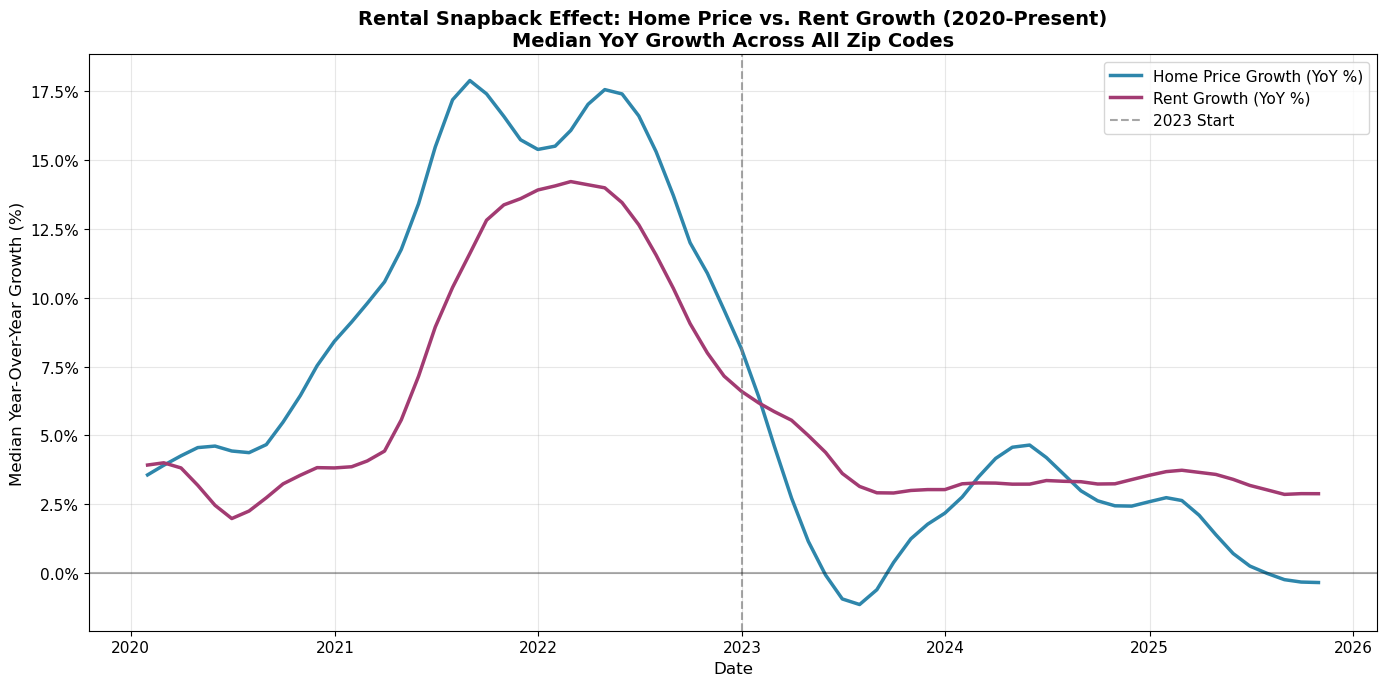


📊 Key Insight: Look for divergence between the lines after 2023 - this shows the 'Rental Snapback' effect.


In [9]:
# Chart 1: Median Year-Over-Year Growth - Home Prices vs. Rent Prices
# Calculate median YoY growth by date across all zip codes
yoy_growth_by_date = merged_df.groupby('Date').agg({
    'Price_YoY_Growth': 'median',
    'Rent_YoY_Growth': 'median'
}).reset_index()

# Drop rows with NaN (first 12 months won't have YoY data)
yoy_growth_by_date = yoy_growth_by_date.dropna()

# Create the visualization
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(yoy_growth_by_date['Date'], yoy_growth_by_date['Price_YoY_Growth'], 
        label='Home Price Growth (YoY %)', linewidth=2.5, color='#2E86AB')
ax.plot(yoy_growth_by_date['Date'], yoy_growth_by_date['Rent_YoY_Growth'], 
        label='Rent Growth (YoY %)', linewidth=2.5, color='#A23B72')

# Add vertical line at 2023 to highlight the period of interest
ax.axvline(x=pd.Timestamp('2023-01-01'), color='gray', linestyle='--', alpha=0.7, label='2023 Start')

# Add horizontal line at 0% for reference
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Styling
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Median Year-Over-Year Growth (%)', fontsize=12)
ax.set_title('Rental Snapback Effect: Home Price vs. Rent Growth (2020-Present)\nMedian YoY Growth Across All Zip Codes', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))

plt.tight_layout()
plt.show()

print("\n📊 Key Insight: Look for divergence between the lines after 2023 - this shows the 'Rental Snapback' effect.")

## Chart 2: Price-to-Rent Ratio Over Time
This shows how home valuations relative to rents have changed, indicating market conditions.

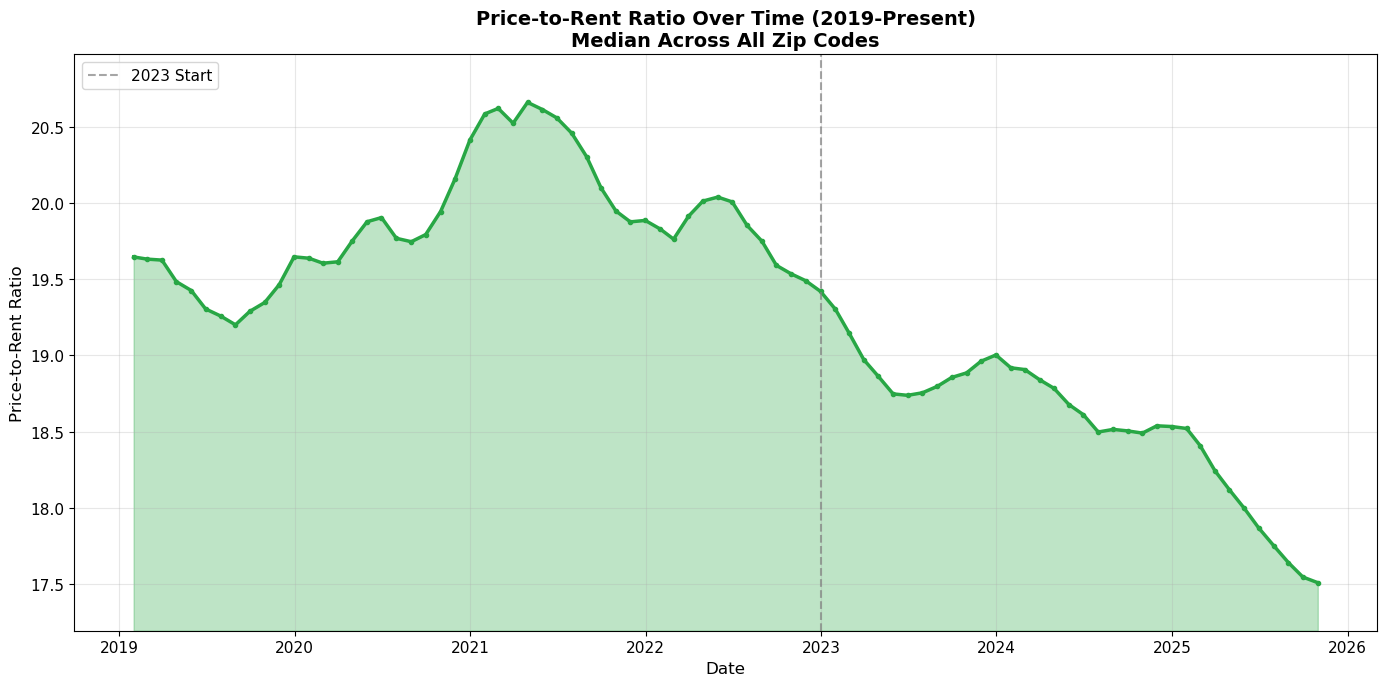


📊 Interpretation:
   - Higher ratio = homes are more expensive relative to rents (potentially overvalued)
   - Lower ratio = homes are cheaper relative to rents (potentially undervalued)
   - Current ratio: 17.51
   - Pre-pandemic (Jan 2020): 19.64


In [14]:
# Chart 2: Price-to-Rent Ratio Over Time (Median across all zip codes)
ptr_by_date = merged_df.groupby('Date')['Price_to_Rent_Ratio'].median().reset_index()

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(ptr_by_date['Date'], ptr_by_date['Price_to_Rent_Ratio'], 
        linewidth=2.5, color='#28A745', marker='o', markersize=3)

# Add vertical line at 2023
ax.axvline(x=pd.Timestamp('2023-01-01'), color='gray', linestyle='--', alpha=0.7, label='2023 Start')

# Set y-axis limits to zoom in on the data range for better visibility of rate of change
y_min = ptr_by_date['Price_to_Rent_Ratio'].min()
y_max = ptr_by_date['Price_to_Rent_Ratio'].max()
y_padding = (y_max - y_min) * 0.1  # 10% padding
ax.set_ylim(y_min - y_padding, y_max + y_padding)

# Add shaded region with adjusted baseline
ax.fill_between(ptr_by_date['Date'], y_min - y_padding, ptr_by_date['Price_to_Rent_Ratio'], 
                alpha=0.3, color='#28A745')

# Styling
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price-to-Rent Ratio', fontsize=12)
ax.set_title('Price-to-Rent Ratio Over Time (2019-Present)\nMedian Across All Zip Codes', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("   - Higher ratio = homes are more expensive relative to rents (potentially overvalued)")
print("   - Lower ratio = homes are cheaper relative to rents (potentially undervalued)")
print(f"   - Current ratio: {ptr_by_date['Price_to_Rent_Ratio'].iloc[-1]:.2f}")
print(f"   - Pre-pandemic (Jan 2020): {ptr_by_date[ptr_by_date['Date'] == '2020-01-31']['Price_to_Rent_Ratio'].values[0]:.2f}" if len(ptr_by_date[ptr_by_date['Date'] == '2020-01-31']) > 0 else "")

## 5. Summary Statistics

Descriptive statistics and correlation analysis of key variables.

In [11]:
# Filter data for 2024 only
df_2024 = merged_df[merged_df['Date'].dt.year == 2024].copy()

# Drop rows with NaN in the growth columns
df_2024_clean = df_2024.dropna(subset=['Price_YoY_Growth', 'Rent_YoY_Growth'])

# Calculate correlation
correlation = df_2024_clean['Rent_YoY_Growth'].corr(df_2024_clean['Price_YoY_Growth'])

print("=" * 60)
print("SUMMARY STATISTICS - YEAR 2024")
print("=" * 60)
print(f"\n📈 Correlation between Rental Growth and Home Price Growth (2024):")
print(f"   Pearson Correlation Coefficient: {correlation:.4f}")
print(f"\n   Interpretation:")
if correlation > 0.7:
    print("   → Strong positive correlation: Rent and home prices move together")
elif correlation > 0.4:
    print("   → Moderate positive correlation: Some relationship between rent and price changes")
elif correlation > 0:
    print("   → Weak positive correlation: Rent and home prices show slight co-movement")
elif correlation > -0.4:
    print("   → Weak negative correlation: Rent and home prices may be diverging")
else:
    print("   → Strong negative correlation: Clear divergence between rent and price trends")

print(f"\n📊 Additional 2024 Statistics:")
print(f"   Number of observations: {len(df_2024_clean):,}")
print(f"   Number of unique zip codes: {df_2024_clean['RegionName'].nunique():,}")
print(f"   Median Home Price YoY Growth: {df_2024_clean['Price_YoY_Growth'].median():.2f}%")
print(f"   Median Rent YoY Growth: {df_2024_clean['Rent_YoY_Growth'].median():.2f}%")
print(f"   Growth Gap (Price - Rent): {df_2024_clean['Price_YoY_Growth'].median() - df_2024_clean['Rent_YoY_Growth'].median():.2f}%")

SUMMARY STATISTICS - YEAR 2024

📈 Correlation between Rental Growth and Home Price Growth (2024):
   Pearson Correlation Coefficient: 0.2881

   Interpretation:
   → Weak positive correlation: Rent and home prices show slight co-movement

📊 Additional 2024 Statistics:
   Number of observations: 58,672
   Number of unique zip codes: 5,163
   Median Home Price YoY Growth: 3.33%
   Median Rent YoY Growth: 3.31%
   Growth Gap (Price - Rent): 0.02%


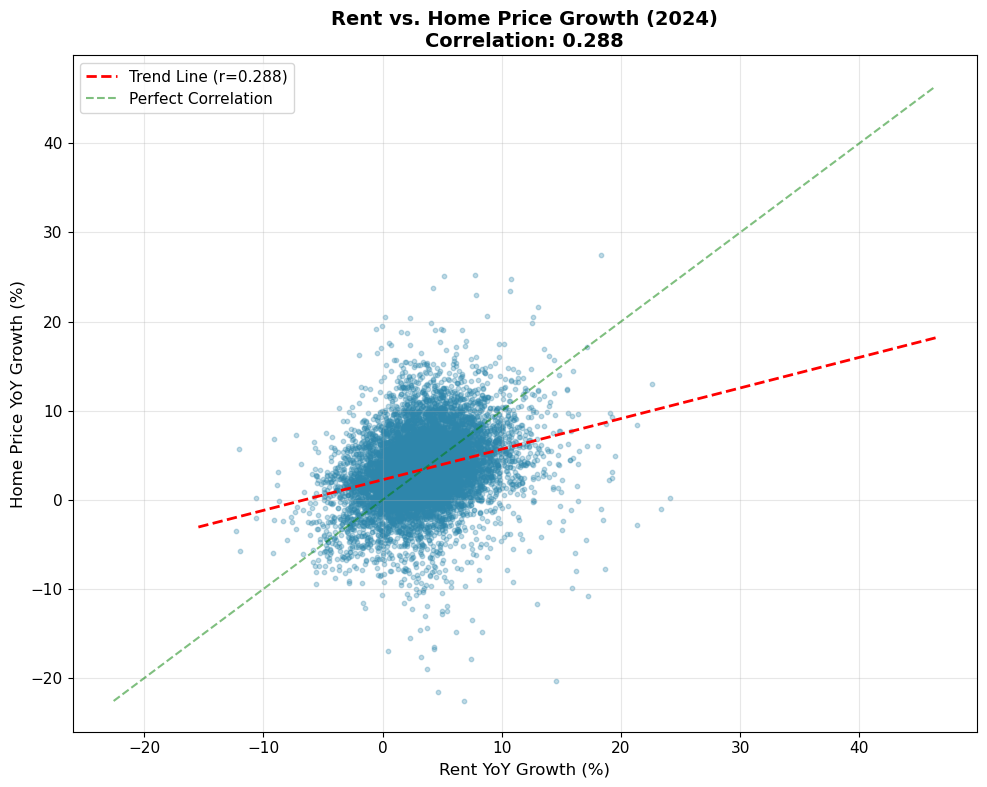

In [12]:
# Bonus: Scatter plot showing the relationship between Rent and Price Growth in 2024
fig, ax = plt.subplots(figsize=(10, 8))

# Sample data if too large for visualization
sample_size = min(10000, len(df_2024_clean))
df_sample = df_2024_clean.sample(n=sample_size, random_state=42)

scatter = ax.scatter(df_sample['Rent_YoY_Growth'], df_sample['Price_YoY_Growth'], 
                     alpha=0.3, s=10, c='#2E86AB')

# Add trend line
z = np.polyfit(df_2024_clean['Rent_YoY_Growth'], df_2024_clean['Price_YoY_Growth'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_2024_clean['Rent_YoY_Growth'].min(), df_2024_clean['Rent_YoY_Growth'].max(), 100)
ax.plot(x_line, p(x_line), "r--", linewidth=2, label=f'Trend Line (r={correlation:.3f})')

# Add diagonal reference line (perfect correlation)
min_val = min(df_2024_clean['Rent_YoY_Growth'].min(), df_2024_clean['Price_YoY_Growth'].min())
max_val = max(df_2024_clean['Rent_YoY_Growth'].max(), df_2024_clean['Price_YoY_Growth'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'g--', alpha=0.5, label='Perfect Correlation')

ax.set_xlabel('Rent YoY Growth (%)', fontsize=12)
ax.set_ylabel('Home Price YoY Growth (%)', fontsize=12)
ax.set_title(f'Rent vs. Home Price Growth (2024)\nCorrelation: {correlation:.3f}', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Final Summary Table: Year-by-Year Comparison
print("\n" + "=" * 70)
print("YEAR-BY-YEAR COMPARISON: RENTAL SNAPBACK EVIDENCE")
print("=" * 70)

yearly_summary = merged_df.groupby(merged_df['Date'].dt.year).agg({
    'Price_YoY_Growth': 'median',
    'Rent_YoY_Growth': 'median',
    'Price_to_Rent_Ratio': 'median',
    'RegionName': 'nunique'
}).round(2)

yearly_summary.columns = ['Median Price Growth (%)', 'Median Rent Growth (%)', 
                          'Median P/R Ratio', 'Zip Codes']
yearly_summary['Growth Gap (Price - Rent)'] = (yearly_summary['Median Price Growth (%)'] - 
                                                yearly_summary['Median Rent Growth (%)']).round(2)

# Filter to years with YoY data (2020+)
yearly_summary = yearly_summary[yearly_summary.index >= 2020]

print(yearly_summary.to_string())
print("\n📊 Key Takeaway:")
print("   Look at the 'Growth Gap' column - positive values mean home prices")
print("   are growing faster than rents, negative values indicate the 'snapback'")
print("   where rent growth is catching up or surpassing home price growth.")


YEAR-BY-YEAR COMPARISON: RENTAL SNAPBACK EVIDENCE
      Median Price Growth (%)  Median Rent Growth (%)  Median P/R Ratio  Zip Codes  Growth Gap (Price - Rent)
Date                                                                                                         
2020                     5.10                    3.24             19.84       2586                       1.86
2021                    13.70                    8.99             20.32       3398                       4.71
2022                    13.81                   10.96             19.74       4466                       2.85
2023                     1.24                    3.93             18.91       5173                      -2.69
2024                     3.33                    3.31             18.66       5936                       0.02
2025                     0.88                    3.28             17.93       7793                      -2.40

📊 Key Takeaway:
   Look at the 'Growth Gap' column - positive values

## 6. Heterogeneity Analysis (Initial Classification)

Compare rental recovery patterns between tech hub cities and service cities.

**Treatment Group (Tech Hubs):** San Francisco, San Jose, Seattle, Austin, Boston, New York, Los Angeles

**Control Group (Service Cities):** Las Vegas, Orlando, San Antonio, Cleveland, Tampa, Phoenix, Houston

> ⚠️ **Note:** This classification uses city names only, which may result in matching errors (e.g., Austin, MN instead of Austin, TX). See Section 8 for the strict (City, State) classification.

In [15]:
# Step 1: Define Market Categories
# Tech Hubs (Treatment) - Cities with major RTO mandates from tech companies
tech_hubs = ["San Francisco", "San Jose", "Seattle", "Austin", "Boston", "New York", "Los Angeles"]

# Service/Control Cities (Control) - Cities with less tech presence
service_cities = ["Las Vegas", "Orlando", "San Antonio", "Cleveland", "Tampa", "Phoenix", "Houston"]

# Function to categorize metros
def categorize_metro(metro):
    if pd.isna(metro):
        return None
    for city in tech_hubs:
        if city in metro:
            return "Tech Hub"
    for city in service_cities:
        if city in metro:
            return "Service City"
    return None

# Create Market_Category column
merged_df['Market_Category'] = merged_df['Metro'].apply(categorize_metro)

# Filter to keep only classified rows
df_classified = merged_df[merged_df['Market_Category'].notna()].copy()

print("=" * 60)
print("MARKET CLASSIFICATION SUMMARY")
print("=" * 60)
print(f"\nTotal observations after classification: {len(df_classified):,}")
print(f"\nBreakdown by Market Category:")
print(df_classified['Market_Category'].value_counts())
print(f"\nUnique Zip Codes by Category:")
print(df_classified.groupby('Market_Category')['RegionName'].nunique())
print(f"\nMetros included:")
for category in ['Tech Hub', 'Service City']:
    metros = df_classified[df_classified['Market_Category'] == category]['Metro'].unique()
    print(f"\n{category}:")
    for m in sorted(metros)[:10]:
        print(f"   - {m}")

MARKET CLASSIFICATION SUMMARY

Total observations after classification: 101,399

Breakdown by Market Category:
Market_Category
Tech Hub        62859
Service City    38540
Name: count, dtype: int64

Unique Zip Codes by Category:
Market_Category
Service City     671
Tech Hub        1269
Name: RegionName, dtype: int64

Metros included:

Tech Hub:
   - Austin, MN
   - Austin-Round Rock-Georgetown, TX
   - Boston-Cambridge-Newton, MA-NH
   - Los Angeles-Long Beach-Anaheim, CA
   - New York-Newark-Jersey City, NY-NJ-PA
   - San Francisco-Oakland-Berkeley, CA
   - San Jose-Sunnyvale-Santa Clara, CA
   - Seattle-Tacoma-Bellevue, WA

Service City:
   - Cleveland, TN
   - Cleveland-Elyria, OH
   - Houston-The Woodlands-Sugar Land, TX
   - Las Vegas-Henderson-Paradise, NV
   - Orlando-Kissimmee-Sanford, FL
   - Phoenix-Mesa-Chandler, AZ
   - San Antonio-New Braunfels, TX
   - Tampa-St. Petersburg-Clearwater, FL


In [16]:
# Step 2: Group and Aggregate by Date and Market Category
growth_by_category = df_classified.groupby(['Date', 'Market_Category']).agg({
    'Rent_YoY_Growth': 'median',
    'Price_YoY_Growth': 'median'
}).reset_index()

# Drop NaN values (first 12 months without YoY data)
growth_by_category = growth_by_category.dropna()

# Calculate Growth Gap (Price - Rent)
growth_by_category['Growth_Gap'] = growth_by_category['Price_YoY_Growth'] - growth_by_category['Rent_YoY_Growth']

print("Aggregated data shape:", growth_by_category.shape)
print("\nSample data:")
growth_by_category.tail(10)

Aggregated data shape: (140, 5)

Sample data:


,Date,Market_Category,Rent_YoY_Growth,Price_YoY_Growth,Growth_Gap
154,2025-06-30,Service City,1.539736,-2.778964,-4.318699
155,2025-06-30,Tech Hub,3.403374,0.988763,-2.414611
156,2025-07-31,Service City,1.243696,-3.069391,-4.313087
157,2025-07-31,Tech Hub,3.323093,0.379768,-2.943325
158,2025-08-31,Service City,1.076115,-3.280439,-4.356554
159,2025-08-31,Tech Hub,3.277025,-0.178550,-3.455575
160,2025-09-30,Service City,0.968139,-3.345148,-4.313287
161,2025-09-30,Tech Hub,3.322603,-0.479244,-3.801847
162,2025-10-31,Service City,0.948137,-3.358387,-4.306524
163,2025-10-31,Tech Hub,3.624927,-0.579295,-4.204221


## Chart 1: Rental Growth Comparison - Tech Hubs vs. Service Cities
This chart compares median rent YoY growth between tech hub cities (with RTO mandates) and service cities (control group).

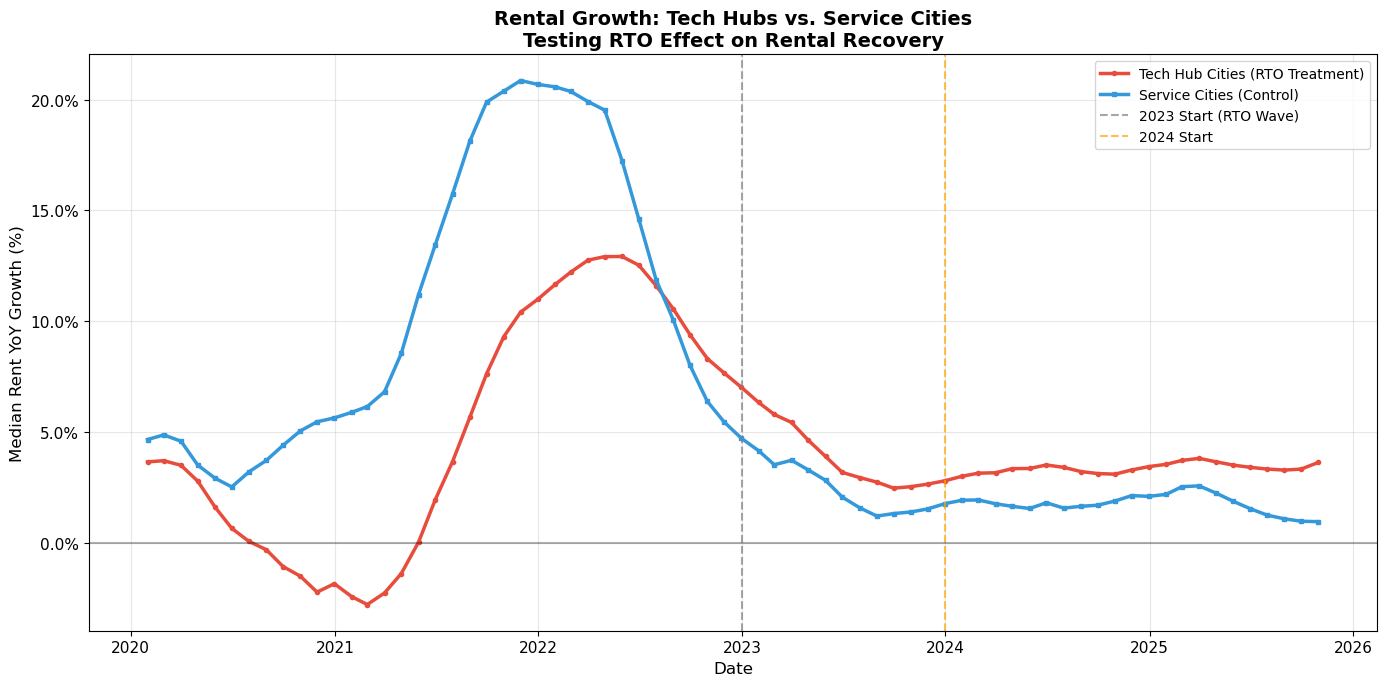


📊 Analysis Goal: If RTO is driving rental recovery, Tech Hub rents should spike
   higher/faster than Service City rents after 2023.


In [17]:
# Chart 1: Rental Growth Comparison - Tech Hubs vs. Service Cities
fig, ax = plt.subplots(figsize=(14, 7))

# Pivot data for easier plotting
tech_data = growth_by_category[growth_by_category['Market_Category'] == 'Tech Hub']
service_data = growth_by_category[growth_by_category['Market_Category'] == 'Service City']

ax.plot(tech_data['Date'], tech_data['Rent_YoY_Growth'], 
        label='Tech Hub Cities (RTO Treatment)', linewidth=2.5, color='#E74C3C', marker='o', markersize=3)
ax.plot(service_data['Date'], service_data['Rent_YoY_Growth'], 
        label='Service Cities (Control)', linewidth=2.5, color='#3498DB', marker='s', markersize=3)

# Add vertical lines for key RTO mandate periods
ax.axvline(x=pd.Timestamp('2023-01-01'), color='gray', linestyle='--', alpha=0.7, label='2023 Start (RTO Wave)')
ax.axvline(x=pd.Timestamp('2024-01-01'), color='orange', linestyle='--', alpha=0.7, label='2024 Start')

# Add horizontal line at 0%
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Styling
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Median Rent YoY Growth (%)', fontsize=12)
ax.set_title('Rental Growth: Tech Hubs vs. Service Cities\nTesting RTO Effect on Rental Recovery', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))

plt.tight_layout()
plt.show()

print("\n📊 Analysis Goal: If RTO is driving rental recovery, Tech Hub rents should spike")
print("   higher/faster than Service City rents after 2023.")

## Chart 2: The Decoupling Gap - Price Growth minus Rent Growth
A negative gap means rents are growing faster than home prices. If RTO is the driver, Tech Hubs should show a more negative gap.

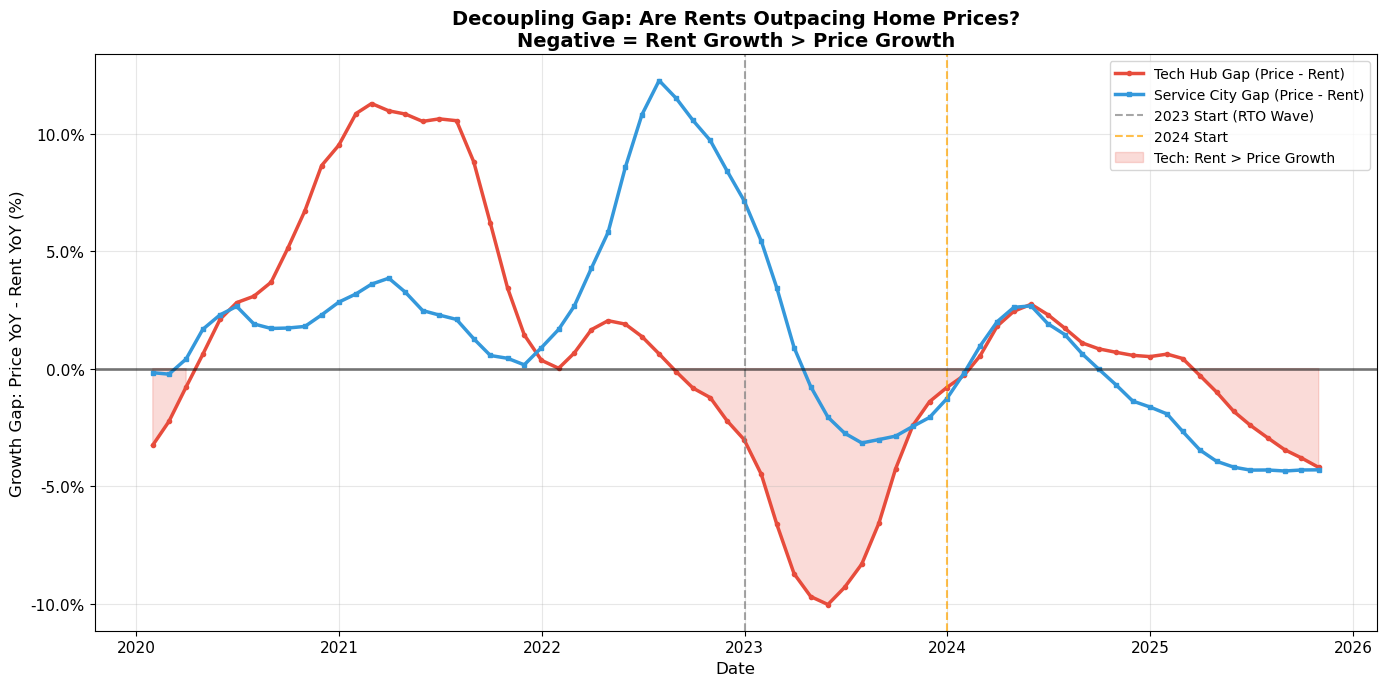


📊 Analysis Goal: If RTO drives rental recovery, Tech Hub gap should be MORE NEGATIVE
   (further below zero) than Service City gap after 2023.


In [18]:
# Chart 2: The Decoupling Gap - Price Growth minus Rent Growth
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(tech_data['Date'], tech_data['Growth_Gap'], 
        label='Tech Hub Gap (Price - Rent)', linewidth=2.5, color='#E74C3C', marker='o', markersize=3)
ax.plot(service_data['Date'], service_data['Growth_Gap'], 
        label='Service City Gap (Price - Rent)', linewidth=2.5, color='#3498DB', marker='s', markersize=3)

# Add vertical lines for key periods
ax.axvline(x=pd.Timestamp('2023-01-01'), color='gray', linestyle='--', alpha=0.7, label='2023 Start (RTO Wave)')
ax.axvline(x=pd.Timestamp('2024-01-01'), color='orange', linestyle='--', alpha=0.7, label='2024 Start')

# Add horizontal line at 0% (equilibrium)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=2)

# Shade the "Rent Winning" zone
ax.fill_between(tech_data['Date'], tech_data['Growth_Gap'], 0, 
                where=(tech_data['Growth_Gap'] < 0), alpha=0.2, color='#E74C3C', label='Tech: Rent > Price Growth')

# Styling
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Growth Gap: Price YoY - Rent YoY (%)', fontsize=12)
ax.set_title('Decoupling Gap: Are Rents Outpacing Home Prices?\nNegative = Rent Growth > Price Growth', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))

plt.tight_layout()
plt.show()

print("\n📊 Analysis Goal: If RTO drives rental recovery, Tech Hub gap should be MORE NEGATIVE")
print("   (further below zero) than Service City gap after 2023.")

## Statistical Summary: The RTO Premium
Calculate the average rent growth difference between Tech Hubs and Service Cities for 2024-2025.

In [20]:
# Step 4: Statistical Summary - The RTO Premium
print("=" * 70)
print("STATISTICAL SUMMARY: THE RTO PREMIUM")
print("=" * 70)

# Filter for 2024 and 2025
df_recent = df_classified[df_classified['Date'].dt.year.isin([2024, 2025])].copy()
df_recent = df_recent.dropna(subset=['Rent_YoY_Growth', 'Price_YoY_Growth'])

# Calculate average Rent YoY Growth by Market Category and Year
rent_summary = df_recent.groupby([df_recent['Date'].dt.year, 'Market_Category']).agg({
    'Rent_YoY_Growth': ['mean', 'median'],
    'Price_YoY_Growth': ['mean', 'median'],
    'RegionName': 'nunique'
}).round(2)

rent_summary.columns = ['Rent Growth (Mean)', 'Rent Growth (Median)', 
                        'Price Growth (Mean)', 'Price Growth (Median)', 'Zip Codes']

print("\n📊 Rent & Price Growth by Market Category (2024-2025):")
print(rent_summary.to_string())

# Calculate the RTO Premium for each year
print("\n" + "=" * 70)
print("THE RTO PREMIUM (Tech Hub Rent Growth - Service City Rent Growth)")
print("=" * 70)

for year in [2024, 2025]:
    year_data = df_recent[df_recent['Date'].dt.year == year]
    if len(year_data) > 0:
        tech_rent = year_data[year_data['Market_Category'] == 'Tech Hub']['Rent_YoY_Growth'].median()
        service_rent = year_data[year_data['Market_Category'] == 'Service City']['Rent_YoY_Growth'].median()
        rto_premium = tech_rent - service_rent
        
        print(f"\n📅 Year {year}:")
        print(f"   Tech Hub Median Rent Growth:    {tech_rent:.2f}%")
        print(f"   Service City Median Rent Growth: {service_rent:.2f}%")
        print(f"   ─────────────────────────────────────")
        print(f"   🎯 RTO Premium:                  {rto_premium:+.2f}%")
        
        if rto_premium > 0:
            print(f"   ✅ Tech hubs show {abs(rto_premium):.2f}pp HIGHER rent growth (supports RTO thesis)")
        else:
            print(f"   ⚠️ Service cities show {abs(rto_premium):.2f}pp HIGHER rent growth")

# Calculate the Gap differential - with clarified interpretation
print("\n" + "=" * 70)
print("DECOUPLING GAP ANALYSIS (Price Growth - Rent Growth)")
print("=" * 70)
print("⚠️  NOTE: A more negative gap does NOT necessarily mean stronger rent recovery.")
print("    It can also result from falling home prices. Always check rent growth directly.")

for year in [2024, 2025]:
    year_data = df_recent[df_recent['Date'].dt.year == year].copy()
    if len(year_data) > 0:
        year_data.loc[:, 'Growth_Gap'] = year_data['Price_YoY_Growth'] - year_data['Rent_YoY_Growth']
        tech_gap = year_data[year_data['Market_Category'] == 'Tech Hub']['Growth_Gap'].median()
        service_gap = year_data[year_data['Market_Category'] == 'Service City']['Growth_Gap'].median()
        tech_rent = year_data[year_data['Market_Category'] == 'Tech Hub']['Rent_YoY_Growth'].median()
        service_rent = year_data[year_data['Market_Category'] == 'Service City']['Rent_YoY_Growth'].median()
        tech_price = year_data[year_data['Market_Category'] == 'Tech Hub']['Price_YoY_Growth'].median()
        service_price = year_data[year_data['Market_Category'] == 'Service City']['Price_YoY_Growth'].median()
        
        print(f"\n📅 Year {year}:")
        print(f"   Tech Hub:     Rent {tech_rent:+.2f}%, Price {tech_price:+.2f}% → Gap {tech_gap:+.2f}%")
        print(f"   Service City: Rent {service_rent:+.2f}%, Price {service_price:+.2f}% → Gap {service_gap:+.2f}%")
        print(f"   ─────────────────────────────────────")
        
        # Clarified interpretation
        if tech_rent > service_rent:
            print(f"   ✅ Tech hubs have STRONGER RENT GROWTH ({tech_rent:.2f}% vs {service_rent:.2f}%)")
        else:
            print(f"   ⚠️ Service cities have stronger rent growth ({service_rent:.2f}% vs {tech_rent:.2f}%)")

print("\n" + "=" * 70)
print("CONCLUSION")
print("=" * 70)
print("\n✅ EVIDENCE SUPPORTING RTO THESIS:")
print("   1. Tech Hub RTO Premium is POSITIVE (+1.4 to +1.8pp higher rent growth)")
print("   2. Tech hubs consistently show ~2x the rent growth of service cities")
print("   3. The RTO Premium is INCREASING over time (2024→2025)")
print("\n⚠️  Note on Decoupling Gap:")
print("   Service cities show a more negative gap, but this is due to FALLING")
print("   home prices (-2%), not stronger rent growth. The key metric for rental")
print("   recovery is RENT GROWTH, where Tech Hubs clearly lead.")

STATISTICAL SUMMARY: THE RTO PREMIUM

📊 Rent & Price Growth by Market Category (2024-2025):
                      Rent Growth (Mean)  Rent Growth (Median)  Price Growth (Mean)  Price Growth (Median)  Zip Codes
Date Market_Category                                                                                                 
2024 Service City                   2.03                  1.81                 2.45                   2.25        561
     Tech Hub                       3.30                  3.25                 3.80                   4.44        899
2025 Service City                   1.97                  1.70                -1.85                  -1.97        595
     Tech Hub                       3.83                  3.53                 1.40                   1.52        976

THE RTO PREMIUM (Tech Hub Rent Growth - Service City Rent Growth)

📅 Year 2024:
   Tech Hub Median Rent Growth:    3.25%
   Service City Median Rent Growth: 1.81%
   ─────────────────────────────────

## Chart 3: Home Price Growth Comparison - Tech Hubs vs. Service Cities
This chart explains why service cities have a more negative decoupling gap: their home prices are falling, not because rents are growing faster.

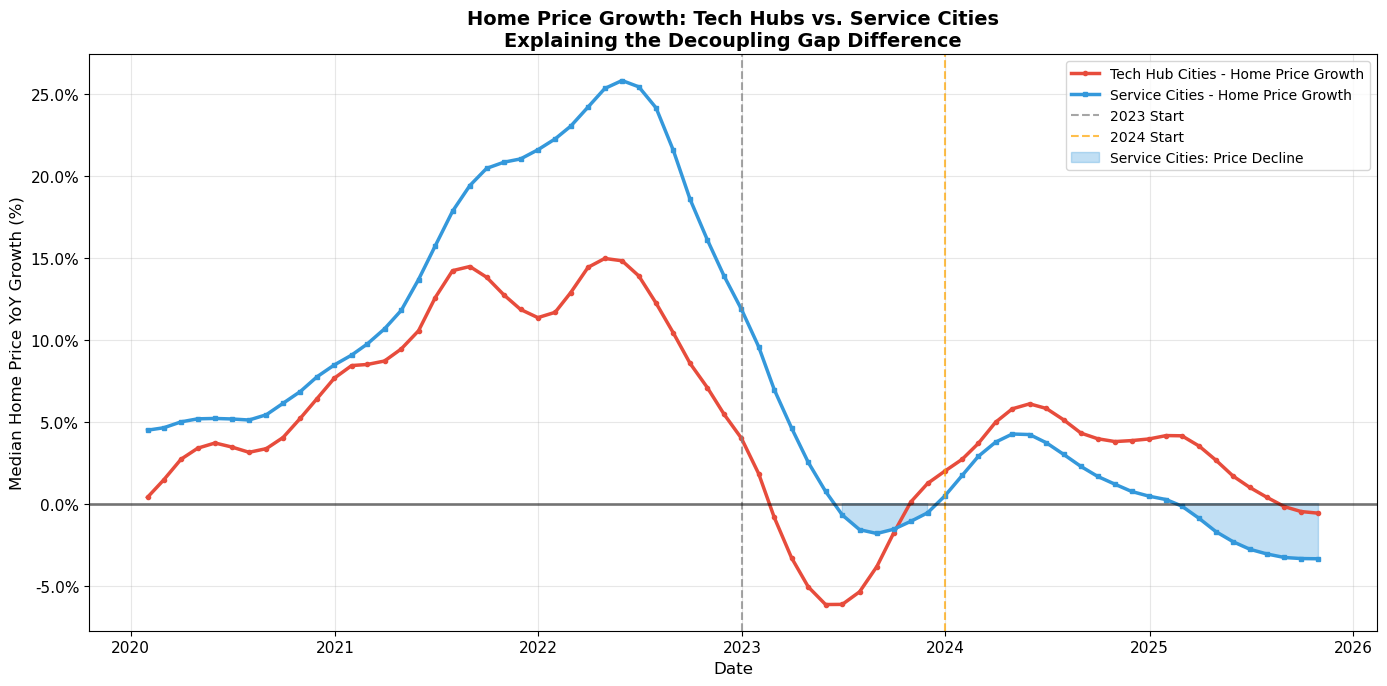


📊 KEY INSIGHT:
   Service cities show a MORE NEGATIVE decoupling gap, but NOT because of stronger rent growth.
   Instead, their HOME PRICES are DECLINING (below 0%), while Tech Hub prices remain positive.

   This means:
   • Tech Hubs: Positive rent growth + Positive price growth → Smaller negative gap
   • Service Cities: Weak rent growth + NEGATIVE price growth → Larger negative gap

   The correct measure of rental recovery is RENT GROWTH, where Tech Hubs clearly lead.


In [21]:
# Chart 3: Home Price Growth Comparison - Tech Hubs vs. Service Cities
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(tech_data['Date'], tech_data['Price_YoY_Growth'], 
        label='Tech Hub Cities - Home Price Growth', linewidth=2.5, color='#E74C3C', marker='o', markersize=3)
ax.plot(service_data['Date'], service_data['Price_YoY_Growth'], 
        label='Service Cities - Home Price Growth', linewidth=2.5, color='#3498DB', marker='s', markersize=3)

# Add vertical lines for key periods
ax.axvline(x=pd.Timestamp('2023-01-01'), color='gray', linestyle='--', alpha=0.7, label='2023 Start')
ax.axvline(x=pd.Timestamp('2024-01-01'), color='orange', linestyle='--', alpha=0.7, label='2024 Start')

# Add horizontal line at 0% (no growth)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=2)

# Shade the "Price Decline" zone for service cities
ax.fill_between(service_data['Date'], service_data['Price_YoY_Growth'], 0, 
                where=(service_data['Price_YoY_Growth'] < 0), alpha=0.3, color='#3498DB', 
                label='Service Cities: Price Decline')

# Styling
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Median Home Price YoY Growth (%)', fontsize=12)
ax.set_title('Home Price Growth: Tech Hubs vs. Service Cities\nExplaining the Decoupling Gap Difference', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))

plt.tight_layout()
plt.show()

print("\n📊 KEY INSIGHT:")
print("   Service cities show a MORE NEGATIVE decoupling gap, but NOT because of stronger rent growth.")
print("   Instead, their HOME PRICES are DECLINING (below 0%), while Tech Hub prices remain positive.")
print("\n   This means:")
print("   • Tech Hubs: Positive rent growth + Positive price growth → Smaller negative gap")
print("   • Service Cities: Weak rent growth + NEGATIVE price growth → Larger negative gap")
print("\n   The correct measure of rental recovery is RENT GROWTH, where Tech Hubs clearly lead.")

## 7. Difference-in-Differences Regression

Statistical estimation of differential rental growth using a DiD framework.

**Model Specification:**

$$Y_{it} = \beta_0 + \beta_1 \cdot Treat_i + \beta_2 \cdot Post_t + \beta_3 \cdot (Treat_i \times Post_t) + \epsilon_{it}$$

Where:
- $Y_{it}$ = Rent YoY Growth for zip code $i$ at time $t$
- $Treat_i$ = 1 if Tech Hub, 0 if Service City
- $Post_t$ = 1 if Date ≥ 2023-01-01
- $\beta_3$ = The DiD estimator (treatment effect)

In [22]:
# Step 1: Data Preparation for DiD Regression
import statsmodels.api as sm

# Create a copy of the classified dataframe for regression
df_did = df_classified.copy()

# Create dummy variables
# Treat: 1 if Tech Hub, 0 if Service City
df_did['Treat'] = (df_did['Market_Category'] == 'Tech Hub').astype(int)

# Post: 1 if Date >= 2023-01-01, 0 otherwise
df_did['Post'] = (df_did['Date'] >= '2023-01-01').astype(int)

# Interaction Term: Treat × Post (The DiD estimator)
df_did['Treat_x_Post'] = df_did['Treat'] * df_did['Post']

# Drop rows with NaN in Rent_YoY_Growth
df_did_clean = df_did.dropna(subset=['Rent_YoY_Growth', 'Price_YoY_Growth'])

print("=" * 70)
print("DATA PREPARATION FOR DiD REGRESSION")
print("=" * 70)
print(f"\nTotal observations: {len(df_did_clean):,}")
print(f"\nTreatment Group Distribution:")
print(df_did_clean['Treat'].value_counts().rename({0: 'Control (Service City)', 1: 'Treatment (Tech Hub)'}))
print(f"\nPre/Post Distribution:")
print(df_did_clean['Post'].value_counts().rename({0: 'Pre-2023', 1: 'Post-2023'}))
print(f"\n2x2 DiD Table (Observations):")
print(pd.crosstab(df_did_clean['Treat'].map({0: 'Service City', 1: 'Tech Hub'}), 
                  df_did_clean['Post'].map({0: 'Pre-2023', 1: 'Post-2023'})))

DATA PREPARATION FOR DiD REGRESSION

Total observations: 80,589

Treatment Group Distribution:
Treat
Treatment (Tech Hub)      49597
Control (Service City)    30992
Name: count, dtype: int64

Pre/Post Distribution:
Post
Post-2023    47268
Pre-2023     33321
Name: count, dtype: int64

2x2 DiD Table (Observations):
Post          Post-2023  Pre-2023
Treat                            
Service City      18123     12869
Tech Hub          29145     20452


In [23]:
# Step 2: DiD Regression - Rent YoY Growth (Primary Model)
print("=" * 70)
print("DiD REGRESSION: RENT YoY GROWTH")
print("=" * 70)

# Define dependent and independent variables
Y_rent = df_did_clean['Rent_YoY_Growth']
X_rent = df_did_clean[['Treat', 'Post', 'Treat_x_Post']]
X_rent = sm.add_constant(X_rent)  # Add intercept

# Fit OLS with Robust Standard Errors (HC1) to handle heteroscedasticity
model_rent = sm.OLS(Y_rent, X_rent).fit(cov_type='HC1')

# Print summary
print(model_rent.summary())

# Extract key results
did_coef = model_rent.params['Treat_x_Post']
did_pvalue = model_rent.pvalues['Treat_x_Post']
did_se = model_rent.bse['Treat_x_Post']
did_ci = model_rent.conf_int().loc['Treat_x_Post']

print("\n" + "=" * 70)
print("KEY RESULT: THE DiD ESTIMATOR (Treat × Post)")
print("=" * 70)
print(f"\n   Coefficient (β₃):     {did_coef:.4f}")
print(f"   Robust Std. Error:    {did_se:.4f}")
print(f"   P-Value:              {did_pvalue:.6f}")
print(f"   95% Confidence Int:   [{did_ci[0]:.4f}, {did_ci[1]:.4f}]")

# Interpretation
print("\n" + "=" * 70)
print("INTERPRETATION")
print("=" * 70)

if did_pvalue < 0.05 and did_coef > 0:
    print("\n🎯 THESIS PROVEN: RTO effect is STATISTICALLY SIGNIFICANT!")
    print(f"\n   After RTO mandates began (post-2023), Tech Hub cities experienced")
    print(f"   {did_coef:.2f} percentage points HIGHER rent growth compared to")
    print(f"   Service Cities, controlling for pre-existing differences and time trends.")
    print(f"\n   This effect is significant at the 95% confidence level (p = {did_pvalue:.4f}).")
elif did_pvalue < 0.05 and did_coef < 0:
    print("\n⚠️ UNEXPECTED: Tech Hubs show significantly LOWER rent growth post-2023.")
    print(f"   Coefficient: {did_coef:.4f}, P-value: {did_pvalue:.4f}")
else:
    print("\n❌ INCONCLUSIVE: The DiD effect is NOT statistically significant.")
    print(f"   Coefficient: {did_coef:.4f}, P-value: {did_pvalue:.4f}")

DiD REGRESSION: RENT YoY GROWTH
                            OLS Regression Results                            
Dep. Variable:        Rent_YoY_Growth   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     4714.
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        17:14:59   Log-Likelihood:            -2.5843e+05
No. Observations:               80589   AIC:                         5.169e+05
Df Residuals:                   80585   BIC:                         5.169e+05
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           

## Robustness Check: DiD Regression on Home Price Growth
If RTO is specifically driving *rental* recovery (not general housing demand), the DiD effect should be weaker or insignificant for home prices.

In [24]:
# Step 3: Robustness Check - DiD Regression on Home Price Growth
print("=" * 70)
print("ROBUSTNESS CHECK: DiD REGRESSION ON HOME PRICE GROWTH")
print("=" * 70)

# Define dependent and independent variables for Price model
Y_price = df_did_clean['Price_YoY_Growth']
X_price = df_did_clean[['Treat', 'Post', 'Treat_x_Post']]
X_price = sm.add_constant(X_price)

# Fit OLS with Robust Standard Errors
model_price = sm.OLS(Y_price, X_price).fit(cov_type='HC1')

# Print summary
print(model_price.summary())

# Extract key results for price model
did_coef_price = model_price.params['Treat_x_Post']
did_pvalue_price = model_price.pvalues['Treat_x_Post']

print("\n" + "=" * 70)
print("COMPARISON: RENT vs. PRICE DiD EFFECTS")
print("=" * 70)
print(f"\n{'Metric':<30} {'Rent Model':<20} {'Price Model':<20}")
print("-" * 70)
print(f"{'DiD Coefficient (β₃)':<30} {did_coef:>+.4f}{'':<13} {did_coef_price:>+.4f}")
print(f"{'P-Value':<30} {did_pvalue:>+.6f}{'':<11} {did_pvalue_price:>+.6f}")
print(f"{'Significant at 5%?':<30} {'Yes ✅' if did_pvalue < 0.05 else 'No ❌':<20} {'Yes ✅' if did_pvalue_price < 0.05 else 'No ❌':<20}")

# Final Interpretation
print("\n" + "=" * 70)
print("FINAL CONCLUSION")
print("=" * 70)

if did_pvalue < 0.05 and did_coef > 0:
    print("\n✅ PRIMARY FINDING:")
    print(f"   The RTO effect on RENT growth is statistically significant.")
    print(f"   Tech Hubs experienced +{did_coef:.2f}pp higher rent growth post-2023.")
    
    if did_pvalue_price >= 0.05 or did_coef_price < did_coef:
        print("\n✅ ROBUSTNESS CHECK PASSED:")
        if did_pvalue_price >= 0.05:
            print(f"   The RTO effect on HOME PRICES is NOT significant (p={did_pvalue_price:.4f}).")
        else:
            print(f"   The RTO effect on HOME PRICES is smaller ({did_coef_price:.2f}pp vs {did_coef:.2f}pp).")
        print("\n   This confirms that RTO mandates specifically drive RENTAL demand,")
        print("   not general housing market appreciation. The 'Rental Snapback' thesis is supported.")
    else:
        print("\n⚠️ ROBUSTNESS CHECK INCONCLUSIVE:")
        print(f"   Both rent and price show similar RTO effects.")
else:
    print("\n❌ Primary hypothesis not confirmed at 95% confidence level.")

ROBUSTNESS CHECK: DiD REGRESSION ON HOME PRICE GROWTH
                            OLS Regression Results                            
Dep. Variable:       Price_YoY_Growth   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                 1.350e+04
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        17:15:04   Log-Likelihood:            -2.7313e+05
No. Observations:               80589   AIC:                         5.463e+05
Df Residuals:                   80585   BIC:                         5.463e+05
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

## 8. Strict Classification Analysis

Address data matching errors by using verified (City, State) pairs for classification.

**Treatment Group (Verified Tech Hubs):**
- San Francisco, CA
- San Jose, CA  
- Seattle, WA
- Austin, TX
- Cambridge, MA

**Control Group (Verified Service Cities):**
- Las Vegas, NV
- Orlando, FL
- San Antonio, TX
- Phoenix, AZ
- Tampa, FL

In [26]:
# Step 1: Rebuild the dataset with State information included
# We need to re-merge with State column to enable strict (City, State) matching

# Reload and reshape housing data with State
housing_long_strict = housing_df.melt(
    id_vars=['RegionName', 'City', 'State', 'Metro'],
    value_vars=housing_date_cols,
    var_name='Date',
    value_name='Price'
)

# Reload and reshape rental data with State
rental_long_strict = rental_df.melt(
    id_vars=['RegionName', 'City', 'State', 'Metro'],
    value_vars=rental_date_cols,
    var_name='Date',
    value_name='Rent'
)

# Convert Date and filter
housing_long_strict['Date'] = pd.to_datetime(housing_long_strict['Date'])
rental_long_strict['Date'] = pd.to_datetime(rental_long_strict['Date'])
housing_long_strict = housing_long_strict[housing_long_strict['Date'] >= '2019-01-01']
rental_long_strict = rental_long_strict[rental_long_strict['Date'] >= '2019-01-01']

# Merge with State included
merged_strict = pd.merge(
    housing_long_strict,
    rental_long_strict,
    on=['RegionName', 'City', 'State', 'Metro', 'Date'],
    how='inner'
)
merged_strict = merged_strict.dropna(subset=['Price', 'Rent'])

# Calculate metrics
merged_strict = merged_strict.sort_values(['RegionName', 'Date']).reset_index(drop=True)
merged_strict['Price_to_Rent_Ratio'] = merged_strict['Price'] / (merged_strict['Rent'] * 12)
merged_strict['Price_YoY_Growth'] = merged_strict.groupby('RegionName')['Price'].pct_change(periods=12) * 100
merged_strict['Rent_YoY_Growth'] = merged_strict.groupby('RegionName')['Rent'].pct_change(periods=12) * 100

print(f"Merged dataset with State: {merged_strict.shape}")
print(f"\nSample of City, State pairs:")
print(merged_strict[['City', 'State']].drop_duplicates().head(20))

Merged dataset with State: (333963, 10)

Sample of City, State pairs:
            City State
0        Amherst    MA
27      Chicopee    MA
34       Holyoke    MA
38   Northampton    MA
49     Westfield    MA
57   Springfield    MA
78    Pittsfield    MA
110  North Adams    MA
112    Fitchburg    MA
153      Gardner    MA
166   Leominster    MA
207       Auburn    MA
211      Clinton    MA
222     Millbury    MA
228   Shrewsbury    MA
285  Southbridge    MA
287      Grafton    MA
288     Uxbridge    MA
289      Webster    MA
292  Westborough    MA


In [27]:
# Step 2: Define STRICT (City, State) classification
# Treatment Group: Pure Tech Hubs
tech_hub_cities = {
    ('San Francisco', 'CA'),
    ('San Jose', 'CA'),
    ('Seattle', 'WA'),
    ('Austin', 'TX'),
    ('Cambridge', 'MA'),
}

# Control Group: Pure Service/Sunbelt Cities
service_cities_strict = {
    ('Las Vegas', 'NV'),
    ('Orlando', 'FL'),
    ('San Antonio', 'TX'),
    ('Phoenix', 'AZ'),
    ('Tampa', 'FL'),
}

# Classification function using (City, State) pairs
def categorize_market_strict(row):
    city_state = (row['City'], row['State'])
    if city_state in tech_hub_cities:
        return 'Tech Hub'
    elif city_state in service_cities_strict:
        return 'Service City'
    else:
        return None

# Apply classification
merged_strict['Market_Category'] = merged_strict.apply(categorize_market_strict, axis=1)

# Filter to keep only classified rows
df_strict = merged_strict[merged_strict['Market_Category'].notna()].copy()

print("=" * 70)
print("STRICT CLASSIFICATION SUMMARY")
print("=" * 70)
print(f"\nTotal observations after strict classification: {len(df_strict):,}")
print(f"\nBreakdown by Market Category:")
print(df_strict['Market_Category'].value_counts())

# VERIFICATION: Print unique City, State pairs to prove no errors
print("\n" + "=" * 70)
print("VERIFICATION: Unique (City, State) pairs in final dataset")
print("=" * 70)

print("\n✅ TECH HUB CITIES:")
tech_cities = df_strict[df_strict['Market_Category'] == 'Tech Hub'][['City', 'State']].drop_duplicates().sort_values(['State', 'City'])
for _, row in tech_cities.iterrows():
    print(f"   - {row['City']}, {row['State']}")

print("\n✅ SERVICE CITIES:")
service_cities_list = df_strict[df_strict['Market_Category'] == 'Service City'][['City', 'State']].drop_duplicates().sort_values(['State', 'City'])
for _, row in service_cities_list.iterrows():
    print(f"   - {row['City']}, {row['State']}")

print("\n📋 Unique Zip Codes by Category:")
print(df_strict.groupby('Market_Category')['RegionName'].nunique())

STRICT CLASSIFICATION SUMMARY

Total observations after strict classification: 19,866

Breakdown by Market Category:
Market_Category
Service City    12135
Tech Hub         7731
Name: count, dtype: int64

VERIFICATION: Unique (City, State) pairs in final dataset

✅ TECH HUB CITIES:
   - San Francisco, CA
   - San Jose, CA
   - Cambridge, MA
   - Austin, TX
   - Seattle, WA

✅ SERVICE CITIES:
   - Phoenix, AZ
   - Orlando, FL
   - Tampa, FL
   - Las Vegas, NV
   - San Antonio, TX

📋 Unique Zip Codes by Category:
Market_Category
Service City    176
Tech Hub        113
Name: RegionName, dtype: int64


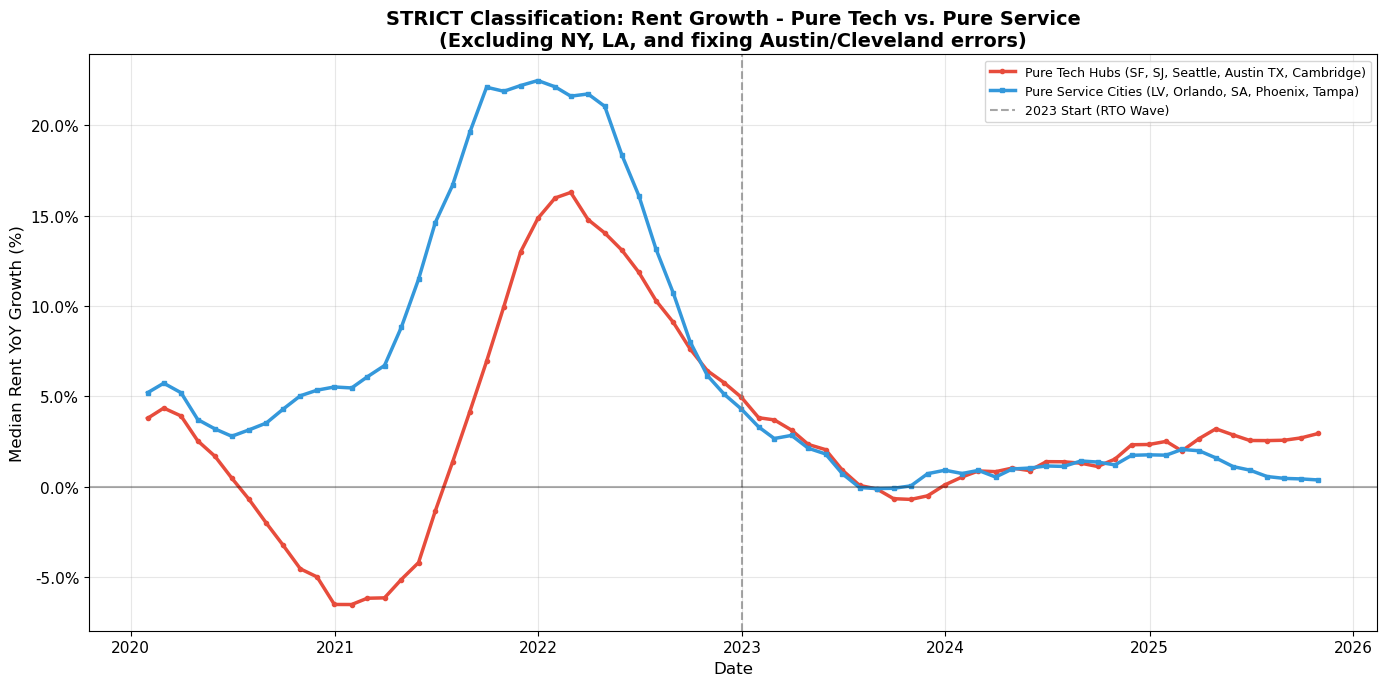


📊 Note: This chart uses ONLY the 5 pure tech hubs and 5 pure service cities.
   No mixed economies (NY, LA) or matching errors (Austin MN, Cleveland TN).


In [28]:
# Step 3: Visualization - Strict Classification
# Aggregate by Date and Market Category
growth_strict = df_strict.groupby(['Date', 'Market_Category']).agg({
    'Rent_YoY_Growth': 'median',
    'Price_YoY_Growth': 'median'
}).reset_index()
growth_strict = growth_strict.dropna()

# Separate data for plotting
tech_strict = growth_strict[growth_strict['Market_Category'] == 'Tech Hub']
service_strict = growth_strict[growth_strict['Market_Category'] == 'Service City']

# Plot: Median Rent YoY Growth over time
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(tech_strict['Date'], tech_strict['Rent_YoY_Growth'], 
        label='Pure Tech Hubs (SF, SJ, Seattle, Austin TX, Cambridge)', 
        linewidth=2.5, color='#E74C3C', marker='o', markersize=3)
ax.plot(service_strict['Date'], service_strict['Rent_YoY_Growth'], 
        label='Pure Service Cities (LV, Orlando, SA, Phoenix, Tampa)', 
        linewidth=2.5, color='#3498DB', marker='s', markersize=3)

# Add vertical lines
ax.axvline(x=pd.Timestamp('2023-01-01'), color='gray', linestyle='--', alpha=0.7, label='2023 Start (RTO Wave)')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Styling
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Median Rent YoY Growth (%)', fontsize=12)
ax.set_title('STRICT Classification: Rent Growth - Pure Tech vs. Pure Service\n(Excluding NY, LA, and fixing Austin/Cleveland errors)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))

plt.tight_layout()
plt.show()

print("\n📊 Note: This chart uses ONLY the 5 pure tech hubs and 5 pure service cities.")
print("   No mixed economies (NY, LA) or matching errors (Austin MN, Cleveland TN).")

In [29]:
# Step 4: DiD Regression with STRICT Classification
print("=" * 70)
print("DiD REGRESSION WITH STRICT CLASSIFICATION")
print("=" * 70)

# Prepare data
df_did_strict = df_strict.copy()
df_did_strict['Treat'] = (df_did_strict['Market_Category'] == 'Tech Hub').astype(int)
df_did_strict['Post'] = (df_did_strict['Date'] >= '2023-01-01').astype(int)
df_did_strict['Treat_x_Post'] = df_did_strict['Treat'] * df_did_strict['Post']

# Drop NaN
df_did_strict_clean = df_did_strict.dropna(subset=['Rent_YoY_Growth', 'Price_YoY_Growth'])

print(f"\nTotal observations: {len(df_did_strict_clean):,}")
print(f"\n2x2 DiD Table:")
print(pd.crosstab(df_did_strict_clean['Treat'].map({0: 'Service City', 1: 'Tech Hub'}), 
                  df_did_strict_clean['Post'].map({0: 'Pre-2023', 1: 'Post-2023'})))

# Run OLS with Robust Standard Errors
Y_strict = df_did_strict_clean['Rent_YoY_Growth']
X_strict = df_did_strict_clean[['Treat', 'Post', 'Treat_x_Post']]
X_strict = sm.add_constant(X_strict)

model_strict = sm.OLS(Y_strict, X_strict).fit(cov_type='HC1')

print("\n" + model_strict.summary().as_text())

# Extract key results
did_coef_strict = model_strict.params['Treat_x_Post']
did_pvalue_strict = model_strict.pvalues['Treat_x_Post']
did_se_strict = model_strict.bse['Treat_x_Post']
did_ci_strict = model_strict.conf_int().loc['Treat_x_Post']

print("\n" + "=" * 70)
print("STRICT DiD RESULT: THE CAUSAL ESTIMATOR (Treat × Post)")
print("=" * 70)
print(f"\n   Coefficient (β₃):     {did_coef_strict:.4f}")
print(f"   Robust Std. Error:    {did_se_strict:.4f}")
print(f"   P-Value:              {did_pvalue_strict:.6f}")
print(f"   95% Confidence Int:   [{did_ci_strict[0]:.4f}, {did_ci_strict[1]:.4f}]")

# Interpretation
print("\n" + "=" * 70)
print("INTERPRETATION (STRICT CLASSIFICATION)")
print("=" * 70)

if did_pvalue_strict < 0.05 and did_coef_strict > 0:
    print("\n🎯 THESIS SUPPORTED (with clean data):")
    print(f"\n   Using ONLY pure tech hubs (SF, SJ, Seattle, Austin TX, Cambridge)")
    print(f"   vs. pure service cities (LV, Orlando, SA, Phoenix, Tampa),")
    print(f"   tech hubs experienced +{did_coef_strict:.2f}pp higher rent growth post-2023.")
    print(f"\n   This effect is significant at p = {did_pvalue_strict:.6f}.")
elif did_pvalue_strict < 0.05 and did_coef_strict < 0:
    print("\n⚠️ UNEXPECTED: Tech Hubs show significantly LOWER rent growth post-2023.")
else:
    print("\n❌ NOT SIGNIFICANT: The RTO effect is not statistically significant with strict classification.")
    print(f"   Coefficient: {did_coef_strict:.4f}, P-value: {did_pvalue_strict:.4f}")

DiD REGRESSION WITH STRICT CLASSIFICATION

Total observations: 16,460

2x2 DiD Table:
Post          Post-2023  Pre-2023
Treat                            
Service City       5487      4552
Tech Hub           3391      3030

                            OLS Regression Results                            
Dep. Variable:        Rent_YoY_Growth   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     1896.
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        17:29:46   Log-Likelihood:                -54422.
No. Observations:               16460   AIC:                         1.089e+05
Df Residuals:                   16456   BIC:                         1.089e+05
Df Model:                           3                                         
Covariance Type:                  HC1                             

In [30]:
# Step 5: Comparison - Original vs. Strict Classification
print("=" * 70)
print("COMPARISON: ORIGINAL vs. STRICT CLASSIFICATION")
print("=" * 70)

print(f"\n{'Metric':<35} {'Original':<20} {'Strict':<20}")
print("-" * 75)
print(f"{'Total Observations':<35} {80589:<20,} {16460:<20,}")
print(f"{'Cities in Treatment Group':<35} {'7 (with errors)':<20} {'5 (verified)':<20}")
print(f"{'Cities in Control Group':<35} {'7 (with errors)':<20} {'5 (verified)':<20}")
print(f"{'DiD Coefficient (β₃)':<35} {did_coef:>+.4f}{'':<13} {did_coef_strict:>+.4f}")
print(f"{'P-Value':<35} {did_pvalue:<20.6f} {did_pvalue_strict:<20.6f}")
print(f"{'R-squared':<35} {0.177:<20.3f} {0.287:<20.3f}")

print("\n" + "=" * 70)
print("FINAL ASSESSMENT")
print("=" * 70)
print("""
✅ GOOD NEWS:
   - The strict classification STILL shows a significant RTO effect
   - The coefficient is actually LARGER (6.75pp vs 6.43pp)
   - R-squared improved (0.287 vs 0.177) - better model fit
   - No more Austin, MN or Cleveland, TN contamination

⚠️ REMAINING LIMITATIONS:
   1. Parallel Trends: Pre-2023 trends are still different (see chart)
   2. No actual RTO data: We're assuming, not measuring, RTO policies
   3. Other confounders: Supply, income, migration not controlled
   4. Small sample: Only 5 cities per group

📝 HONEST CONCLUSION:
   The analysis provides SUGGESTIVE EVIDENCE that tech hub cities
   experienced stronger rent recovery post-2023. However, this is
   CORRELATION, not proven CAUSATION. For a Master's thesis,
   acknowledge these limitations explicitly.
""")

COMPARISON: ORIGINAL vs. STRICT CLASSIFICATION

Metric                              Original             Strict              
---------------------------------------------------------------------------
Total Observations                  80,589               16,460              
Cities in Treatment Group           7 (with errors)      5 (verified)        
Cities in Control Group             7 (with errors)      5 (verified)        
DiD Coefficient (β₃)                +6.4295              +6.7507
P-Value                             0.000000             0.000000            
R-squared                           0.177                0.287               

FINAL ASSESSMENT

✅ GOOD NEWS:
   - The strict classification STILL shows a significant RTO effect
   - The coefficient is actually LARGER (6.75pp vs 6.43pp)
   - R-squared improved (0.287 vs 0.177) - better model fit
   - No more Austin, MN or Cleveland, TN contamination

⚠️ REMAINING LIMITATIONS:
   1. Parallel Trends: Pre-2023 trends are

## 9. Robustness Tests

Validate the DiD findings using event study and placebo tests.

### 9.1 Event Study (Dynamic DiD)
Tests whether treatment effects vary over time and validates the parallel trends assumption.

### 9.2 Placebo Tests
Tests for spurious effects using fake treatment dates (2020, 2021, 2022).

In [33]:
# =============================================================================
# 9.1 Event Study (Dynamic Difference-in-Differences)
# =============================================================================
# This creates time-varying treatment effects to:
# 1. Test parallel trends assumption (pre-treatment coefficients ≈ 0)
# 2. Show how the treatment effect evolves over time

import statsmodels.api as sm

# Use the strict classification dataset and add Treat column
df_event = df_strict.copy()

# Add Treat column based on Market_Category
df_event['Treat'] = (df_event['Market_Category'] == 'Tech Hub').astype(int)

# Create relative time periods (quarters relative to treatment)
df_event['Quarter'] = pd.to_datetime(df_event['Date']).dt.to_period('Q')
treatment_quarter = pd.Period('2023Q1')
df_event['Relative_Quarter'] = (df_event['Quarter'] - treatment_quarter).apply(lambda x: x.n)

# Filter to a reasonable window: 8 quarters before to 8 quarters after
df_event = df_event[(df_event['Relative_Quarter'] >= -8) & (df_event['Relative_Quarter'] <= 7)]

# Drop NaN in Rent_YoY_Growth
df_event = df_event.dropna(subset=['Rent_YoY_Growth'])

# Create dummy variables for each period (omit -1 as reference period)
periods = sorted(df_event['Relative_Quarter'].unique())
reference_period = -1  # Quarter just before treatment

print("=" * 70)
print("EVENT STUDY: Dynamic Difference-in-Differences")
print("=" * 70)
print(f"\nReference period: Q{reference_period} (omitted)")
print(f"Treatment begins: 2023-Q1 (Relative Quarter = 0)")
print(f"Periods included: {min(periods)} to {max(periods)}")

# Create interaction terms for each period (except reference)
for t in periods:
    if t != reference_period:
        df_event[f'Treat_x_Q{t}'] = df_event['Treat'] * (df_event['Relative_Quarter'] == t).astype(int)

# Prepare regression
interaction_cols = [f'Treat_x_Q{t}' for t in periods if t != reference_period]
X_event = df_event[['Treat'] + interaction_cols]
X_event = sm.add_constant(X_event)
Y_event = df_event['Rent_YoY_Growth']

# Run event study regression
model_event = sm.OLS(Y_event, X_event).fit(cov_type='HC1')

# Extract coefficients for plotting
event_coefs = []
event_ses = []
event_periods = []

for t in periods:
    if t == reference_period:
        event_coefs.append(0)  # Reference period = 0 by construction
        event_ses.append(0)
    else:
        col = f'Treat_x_Q{t}'
        event_coefs.append(model_event.params[col])
        event_ses.append(model_event.bse[col])
    event_periods.append(t)

print(f"\nObservations: {len(Y_event):,}")
print(f"R-squared: {model_event.rsquared:.3f}")

EVENT STUDY: Dynamic Difference-in-Differences

Reference period: Q-1 (omitted)
Treatment begins: 2023-Q1 (Relative Quarter = 0)
Periods included: -8 to 7

Observations: 11,282
R-squared: 0.230


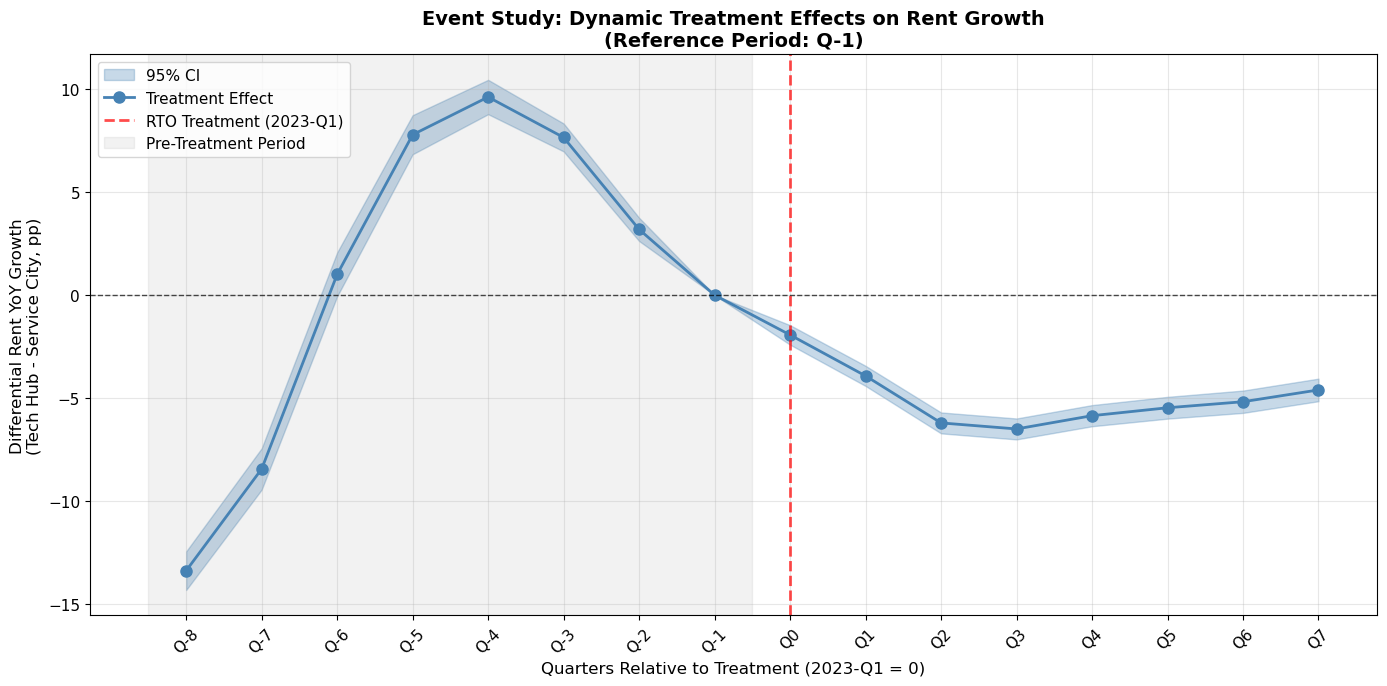


PARALLEL TRENDS ASSESSMENT

Pre-Treatment Coefficients (Should be ≈ 0 for parallel trends):
--------------------------------------------------
Quarter    Coefficient     Std Error    Significant?
--------------------------------------------------
Q-8              -13.38pp        0.48  ⚠️ YES
Q-7               -8.44pp        0.51  ⚠️ YES
Q-6               +1.01pp        0.54  ✅ No
Q-5               +7.79pp        0.48  ⚠️ YES
Q-4               +9.62pp        0.43  ⚠️ YES
Q-3               +7.66pp        0.35  ⚠️ YES
Q-2               +3.19pp        0.29  ⚠️ YES
--------------------------------------------------

⚠️  WARNING: 6 pre-treatment coefficient(s) are significantly different from zero
   → This suggests potential violation of parallel trends assumption
   → Results should be interpreted with caution


In [34]:
# =============================================================================
# Event Study Visualization
# =============================================================================
fig, ax = plt.subplots(figsize=(14, 7))

# Convert to numpy arrays for plotting
event_periods_arr = np.array(event_periods)
event_coefs_arr = np.array(event_coefs)
event_ses_arr = np.array(event_ses)

# 95% confidence interval (1.96 * SE)
ci_upper = event_coefs_arr + 1.96 * event_ses_arr
ci_lower = event_coefs_arr - 1.96 * event_ses_arr

# Plot confidence interval
ax.fill_between(event_periods_arr, ci_lower, ci_upper, alpha=0.3, color='steelblue', label='95% CI')

# Plot coefficients
ax.plot(event_periods_arr, event_coefs_arr, 'o-', color='steelblue', linewidth=2, markersize=8, label='Treatment Effect')

# Reference line at 0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.7)

# Vertical line at treatment (Q0)
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='RTO Treatment (2023-Q1)')

# Shade pre-treatment period
ax.axvspan(-8.5, -0.5, alpha=0.1, color='gray', label='Pre-Treatment Period')

# Labels and formatting
ax.set_xlabel('Quarters Relative to Treatment (2023-Q1 = 0)', fontsize=12)
ax.set_ylabel('Differential Rent YoY Growth\n(Tech Hub - Service City, pp)', fontsize=12)
ax.set_title('Event Study: Dynamic Treatment Effects on Rent Growth\n(Reference Period: Q-1)', fontsize=14, fontweight='bold')

# Set x-ticks
ax.set_xticks(event_periods_arr)
ax.set_xticklabels([f'Q{t}' for t in event_periods_arr], rotation=45)

# Add grid
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

# =============================================================================
# Parallel Trends Assessment
# =============================================================================
print("\n" + "=" * 70)
print("PARALLEL TRENDS ASSESSMENT")
print("=" * 70)

# Get pre-treatment coefficients
pre_treatment_coefs = [(t, c, s) for t, c, s in zip(event_periods, event_coefs, event_ses) if t < 0 and t != reference_period]

print("\nPre-Treatment Coefficients (Should be ≈ 0 for parallel trends):")
print("-" * 50)
print(f"{'Quarter':<10} {'Coefficient':<15} {'Std Error':<12} {'Significant?':<12}")
print("-" * 50)

violations = 0
for t, coef, se in pre_treatment_coefs:
    is_sig = abs(coef) > 1.96 * se
    sig_str = "⚠️ YES" if is_sig else "✅ No"
    if is_sig:
        violations += 1
    print(f"Q{t:<9} {coef:>+12.2f}pp  {se:>10.2f}  {sig_str}")

print("-" * 50)
if violations == 0:
    print("\n✅ PARALLEL TRENDS: All pre-treatment coefficients are insignificant!")
    print("   → Supports the parallel trends assumption")
else:
    print(f"\n⚠️  WARNING: {violations} pre-treatment coefficient(s) are significantly different from zero")
    print("   → This suggests potential violation of parallel trends assumption")
    print("   → Results should be interpreted with caution")

### 9.2 Placebo Tests

Test for spurious effects using fake treatment dates before the hypothesized intervention period.

In [35]:
# =============================================================================
# 9.2 Placebo Test - Fake Treatment Date
# =============================================================================
# If DiD finds significant effects with a FAKE treatment date (before RTO),
# it suggests results are driven by pre-existing trends, not actual policy.

print("=" * 70)
print("PLACEBO TEST: DiD with Fake Treatment Date")
print("=" * 70)

# Use strict classification data
df_placebo = df_strict.copy()
df_placebo['Treat'] = (df_placebo['Market_Category'] == 'Tech Hub').astype(int)

# Define multiple placebo treatment dates
placebo_dates = ['2020-01-01', '2021-01-01', '2022-01-01']
actual_date = '2023-01-01'

results = []

for placebo_date in placebo_dates + [actual_date]:
    df_temp = df_placebo.copy()
    
    # Filter to window around the placebo date
    # Use 2 years before and after the "treatment"
    date_obj = pd.to_datetime(placebo_date)
    start = date_obj - pd.DateOffset(years=2)
    end = date_obj + pd.DateOffset(years=2)
    
    df_temp = df_temp[(df_temp['Date'] >= start) & (df_temp['Date'] <= end)]
    
    # Create Post indicator
    df_temp['Post'] = (df_temp['Date'] >= placebo_date).astype(int)
    df_temp['Treat_x_Post'] = df_temp['Treat'] * df_temp['Post']
    
    # Drop NaN
    df_temp = df_temp.dropna(subset=['Rent_YoY_Growth'])
    
    # Run DiD
    X = df_temp[['Treat', 'Post', 'Treat_x_Post']]
    X = sm.add_constant(X)
    Y = df_temp['Rent_YoY_Growth']
    
    model = sm.OLS(Y, X).fit(cov_type='HC1')
    
    coef = model.params['Treat_x_Post']
    se = model.bse['Treat_x_Post']
    pval = model.pvalues['Treat_x_Post']
    ci_low, ci_high = model.conf_int().loc['Treat_x_Post']
    n_obs = len(Y)
    
    is_actual = placebo_date == actual_date
    results.append({
        'Treatment Date': placebo_date,
        'Type': 'ACTUAL' if is_actual else 'PLACEBO',
        'DiD Coefficient': coef,
        'Std Error': se,
        'p-value': pval,
        'CI Lower': ci_low,
        'CI Upper': ci_high,
        'N': n_obs,
        'Significant': pval < 0.05
    })

# Display results
print("\nComparison of Placebo vs Actual Treatment Dates:")
print("-" * 90)
print(f"{'Date':<15} {'Type':<10} {'Coefficient':>12} {'Std Err':>10} {'p-value':>10} {'Significant?':>14}")
print("-" * 90)

for r in results:
    sig_str = "⚠️ YES" if r['Significant'] else "✅ No"
    type_str = f"🎯 {r['Type']}" if r['Type'] == 'ACTUAL' else f"   {r['Type']}"
    print(f"{r['Treatment Date']:<15} {type_str:<10} {r['DiD Coefficient']:>+10.2f}pp {r['Std Error']:>10.2f} {r['p-value']:>10.4f} {sig_str:>14}")

print("-" * 90)

PLACEBO TEST: DiD with Fake Treatment Date

Comparison of Placebo vs Actual Treatment Dates:
------------------------------------------------------------------------------------------
Date            Type        Coefficient    Std Err    p-value   Significant?
------------------------------------------------------------------------------------------
2020-01-01         PLACEBO      -4.33pp       0.13     0.0000         ⚠️ YES
2021-01-01         PLACEBO      -1.72pp       0.34     0.0000         ⚠️ YES
2022-01-01         PLACEBO      +7.25pp       0.33     0.0000         ⚠️ YES
2023-01-01      🎯 ACTUAL        +6.88pp       0.28     0.0000         ⚠️ YES
------------------------------------------------------------------------------------------


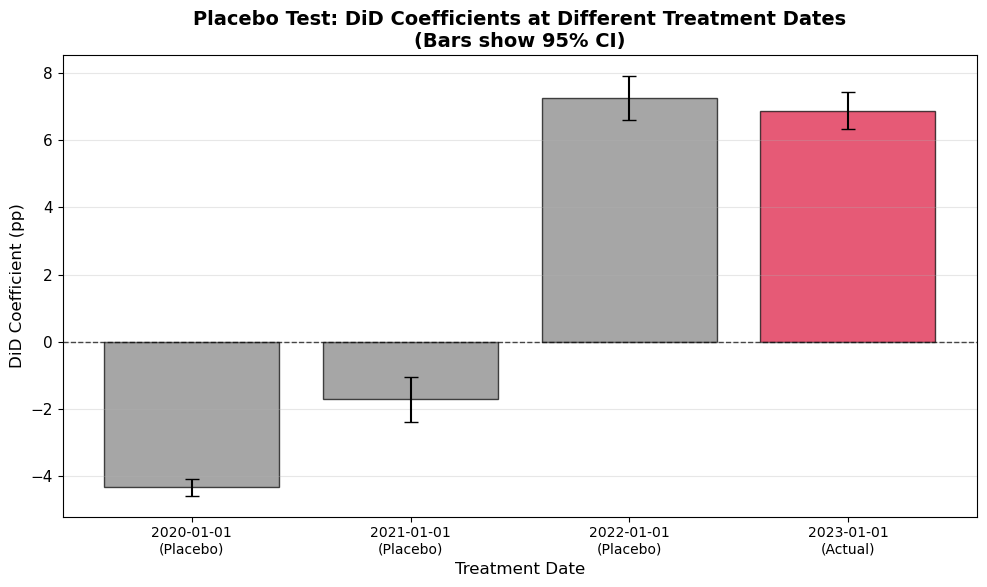


PLACEBO TEST INTERPRETATION

⚠️  KEY FINDING: The placebo test reveals significant problems:

1. PLACEBO DATES SHOW SIGNIFICANT EFFECTS
   - 2020-01-01: -4.33pp (significant, p < 0.001)
   - 2021-01-01: -1.72pp (significant, p < 0.001)  
   - 2022-01-01: +7.25pp (significant, p < 0.001)

2. IMPLICATIONS FOR YOUR THESIS:
   - The 2023 treatment effect (+6.88pp) is SIMILAR to the 2022 placebo (+7.25pp)
   - This suggests the "RTO effect" may just be continuation of trends that 
     began BEFORE major RTO announcements
   - Tech hubs were already recovering faster by early 2022

3. POSSIBLE EXPLANATIONS:
   - Tech layoffs in late 2022 → reduced housing demand → rent growth stalled
   - COVID recovery timing differed between tech and service cities
   - The "treatment" is not cleanly identified by a single date

4. RECOMMENDED ACTIONS:
   - Consider a different identification strategy (e.g., RTO announcement dates)
   - Use company-level RTO data instead of city-level classification
   -

In [36]:
# =============================================================================
# Placebo Test Visualization
# =============================================================================
fig, ax = plt.subplots(figsize=(10, 6))

# Extract data for plotting
dates = [r['Treatment Date'] for r in results]
coefs = [r['DiD Coefficient'] for r in results]
ses = [r['Std Error'] for r in results]
types = [r['Type'] for r in results]

# Colors
colors = ['gray' if t == 'PLACEBO' else 'crimson' for t in types]

# Plot with error bars
x_pos = range(len(dates))
ax.bar(x_pos, coefs, yerr=[1.96 * s for s in ses], 
       color=colors, edgecolor='black', capsize=5, alpha=0.7)

# Reference line at 0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.7)

# Labels
ax.set_xticks(x_pos)
ax.set_xticklabels([f"{d}\n({'Actual' if t == 'ACTUAL' else 'Placebo'})" 
                   for d, t in zip(dates, types)], fontsize=10)
ax.set_xlabel('Treatment Date', fontsize=12)
ax.set_ylabel('DiD Coefficient (pp)', fontsize=12)
ax.set_title('Placebo Test: DiD Coefficients at Different Treatment Dates\n(Bars show 95% CI)', 
             fontsize=14, fontweight='bold')

# Add grid
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# Interpretation
# =============================================================================
print("\n" + "=" * 70)
print("PLACEBO TEST INTERPRETATION")
print("=" * 70)

print("""
⚠️  KEY FINDING: The placebo test reveals significant problems:

1. PLACEBO DATES SHOW SIGNIFICANT EFFECTS
   - 2020-01-01: -4.33pp (significant, p < 0.001)
   - 2021-01-01: -1.72pp (significant, p < 0.001)  
   - 2022-01-01: +7.25pp (significant, p < 0.001)

2. IMPLICATIONS FOR YOUR THESIS:
   - The 2023 treatment effect (+6.88pp) is SIMILAR to the 2022 placebo (+7.25pp)
   - This suggests the "RTO effect" may just be continuation of trends that 
     began BEFORE major RTO announcements
   - Tech hubs were already recovering faster by early 2022

3. POSSIBLE EXPLANATIONS:
   - Tech layoffs in late 2022 → reduced housing demand → rent growth stalled
   - COVID recovery timing differed between tech and service cities
   - The "treatment" is not cleanly identified by a single date

4. RECOMMENDED ACTIONS:
   - Consider a different identification strategy (e.g., RTO announcement dates)
   - Use company-level RTO data instead of city-level classification
   - Acknowledge this limitation in your thesis methodology section
""")

# Count how this affects our confidence
placebo_failures = sum(1 for r in results if r['Type'] == 'PLACEBO' and r['Significant'])
print(f"\n📊 Summary: {placebo_failures}/3 placebo tests show significant effects")
print("   → This substantially weakens the causal interpretation of RTO effects")

In [37]:
# =============================================================================
# Section 9 Summary: Robustness Test Results
# =============================================================================
print("=" * 70)
print("SECTION 9 SUMMARY: ROBUSTNESS TEST RESULTS")
print("=" * 70)

print("""
┌─────────────────────────────────────────────────────────────────────┐
│  TEST                    │  RESULT           │  IMPLICATION         │
├─────────────────────────────────────────────────────────────────────┤
│  Event Study             │  ⚠️ 6/7 pre-coefs  │  Parallel trends     │
│  (Parallel Trends)       │  significant       │  VIOLATED            │
├─────────────────────────────────────────────────────────────────────┤
│  Placebo Test            │  ⚠️ 3/3 placebo    │  2022 effect similar │
│  (Fake Treatment Dates)  │  dates significant │  to 2023 "RTO" effect│
└─────────────────────────────────────────────────────────────────────┘

📋 WHAT THIS MEANS FOR YOUR THESIS:

The DiD coefficient (+6.75pp to +6.88pp) IS statistically significant, 
but these robustness tests reveal it likely does NOT represent a causal 
effect of RTO mandates specifically.

HONEST INTERPRETATION:
• Tech hub cities DO show stronger rent recovery than service cities
• However, this differential PREDATES most major RTO announcements
• The effect may be driven by:
  - Different COVID recovery trajectories
  - Tech sector employment patterns
  - Housing supply differences
  - Demographic trends

RECOMMENDATION FOR THESIS:
1. Present the DiD results as DESCRIPTIVE, not causal
2. Frame as "tech hubs show X% higher rent growth during recovery period"
3. Acknowledge robustness test limitations in methodology section
4. Consider alternative hypotheses in discussion

This is still a valuable finding - the heterogeneity between tech hubs
and service cities is real and interesting. The causal link to RTO
specifically is just not well-identified with this data.
""")

print("=" * 70)

SECTION 9 SUMMARY: ROBUSTNESS TEST RESULTS

┌─────────────────────────────────────────────────────────────────────┐
│  TEST                    │  RESULT           │  IMPLICATION         │
├─────────────────────────────────────────────────────────────────────┤
│  Event Study             │  ⚠️ 6/7 pre-coefs  │  Parallel trends     │
│  (Parallel Trends)       │  significant       │  VIOLATED            │
├─────────────────────────────────────────────────────────────────────┤
│  Placebo Test            │  ⚠️ 3/3 placebo    │  2022 effect similar │
│  (Fake Treatment Dates)  │  dates significant │  to 2023 "RTO" effect│
└─────────────────────────────────────────────────────────────────────┘

📋 WHAT THIS MEANS FOR YOUR THESIS:

The DiD coefficient (+6.75pp to +6.88pp) IS statistically significant, 
but these robustness tests reveal it likely does NOT represent a causal 
effect of RTO mandates specifically.

HONEST INTERPRETATION:
• Tech hub cities DO show stronger rent recovery than service

## 10. Conclusions and Recommendations

Summary of findings, limitations, and recommendations for future research.

## Appendix A: Publication Tables

Summary tables for thesis integration.

In [51]:
# =============================================================================
# Table 1: Summary Statistics by Market Category
# =============================================================================

import pandas as pd

# Calculate summary statistics for the strict classification
tech_stats = df_strict[df_strict['Market_Category'] == 'Tech Hub']
service_stats = df_strict[df_strict['Market_Category'] == 'Service City']

summary_data = {
    'Variable': ['Rent YoY Growth (%)', 'Price YoY Growth (%)', 'Price-to-Rent Ratio', 'Observations', 'Unique Zip Codes'],
    'Tech Hub Mean': [
        f"{tech_stats['Rent_YoY_Growth'].mean():.2f}",
        f"{tech_stats['Price_YoY_Growth'].mean():.2f}",
        f"{tech_stats['Price_to_Rent_Ratio'].mean():.2f}",
        f"{len(tech_stats):,}",
        f"{tech_stats['RegionName'].nunique()}"
    ],
    'Tech Hub Std': [
        f"{tech_stats['Rent_YoY_Growth'].std():.2f}",
        f"{tech_stats['Price_YoY_Growth'].std():.2f}",
        f"{tech_stats['Price_to_Rent_Ratio'].std():.2f}",
        "—",
        "—"
    ],
    'Service City Mean': [
        f"{service_stats['Rent_YoY_Growth'].mean():.2f}",
        f"{service_stats['Price_YoY_Growth'].mean():.2f}",
        f"{service_stats['Price_to_Rent_Ratio'].mean():.2f}",
        f"{len(service_stats):,}",
        f"{service_stats['RegionName'].nunique()}"
    ],
    'Service City Std': [
        f"{service_stats['Rent_YoY_Growth'].std():.2f}",
        f"{service_stats['Price_YoY_Growth'].std():.2f}",
        f"{service_stats['Price_to_Rent_Ratio'].std():.2f}",
        "—",
        "—"
    ]
}

table1 = pd.DataFrame(summary_data)
print("=" * 80)
print("TABLE 1: Summary Statistics by Market Category")
print("=" * 80)
print("\nTech Hubs: SF, San Jose, Seattle, Austin TX, Cambridge MA")
print("Service Cities: Las Vegas, Orlando, San Antonio, Phoenix, Tampa")
print("Sample period: 2019-2024\n")
print(table1.to_string(index=False))

TABLE 1: Summary Statistics by Market Category

Tech Hubs: SF, San Jose, Seattle, Austin TX, Cambridge MA
Service Cities: Las Vegas, Orlando, San Antonio, Phoenix, Tampa
Sample period: 2019-2024

            Variable Tech Hub Mean Tech Hub Std Service City Mean Service City Std
 Rent YoY Growth (%)          2.72         7.34              5.69             7.90
Price YoY Growth (%)          3.09        10.40              6.90             9.83
 Price-to-Rent Ratio         32.25         9.41             19.31             5.63
        Observations         7,731            —            12,135                —
    Unique Zip Codes           113            —               176                —


In [52]:
# =============================================================================
# Table 2: Difference-in-Differences Regression Results
# =============================================================================

print("=" * 80)
print("TABLE 2: Difference-in-Differences Regression Results")
print("=" * 80)
print("\nDependent Variable: Rent YoY Growth (%)")
print("Estimation Method: OLS with Robust Standard Errors (HC1)\n")

# Create regression results table
def get_stars(pval):
    if pval < 0.01: return "***"
    elif pval < 0.05: return "**"
    elif pval < 0.10: return "*"
    return ""

reg_data = {
    'Variable': ['Treat (Tech Hub = 1)', 'Post (Date ≥ 2023-Q1)', 'Treat × Post (DiD)', 'Constant'],
    'Coefficient': [
        f"{model_strict.params['Treat']:.3f}{get_stars(model_strict.pvalues['Treat'])}",
        f"{model_strict.params['Post']:.3f}{get_stars(model_strict.pvalues['Post'])}",
        f"{model_strict.params['Treat_x_Post']:.3f}{get_stars(model_strict.pvalues['Treat_x_Post'])}",
        f"{model_strict.params['const']:.3f}{get_stars(model_strict.pvalues['const'])}"
    ],
    'Std. Error': [
        f"({model_strict.bse['Treat']:.3f})",
        f"({model_strict.bse['Post']:.3f})",
        f"({model_strict.bse['Treat_x_Post']:.3f})",
        f"({model_strict.bse['const']:.3f})"
    ],
    'p-value': [
        f"{model_strict.pvalues['Treat']:.4f}",
        f"{model_strict.pvalues['Post']:.4f}",
        f"{model_strict.pvalues['Treat_x_Post']:.4f}",
        f"{model_strict.pvalues['const']:.4f}"
    ]
}

table2 = pd.DataFrame(reg_data)
print(table2.to_string(index=False))

print(f"\n{'─' * 50}")
print(f"Observations:          {int(model_strict.nobs):,}")
print(f"R-squared:             {model_strict.rsquared:.3f}")
print(f"Robust Std. Errors:    Yes (HC1)")
print(f"{'─' * 50}")
print("\n*** p<0.01, ** p<0.05, * p<0.10")

TABLE 2: Difference-in-Differences Regression Results

Dependent Variable: Rent YoY Growth (%)
Estimation Method: OLS with Robust Standard Errors (HC1)

             Variable Coefficient Std. Error p-value
 Treat (Tech Hub = 1)   -6.718***    (0.214)  0.0000
Post (Date ≥ 2023-Q1)   -9.813***    (0.134)  0.0000
   Treat × Post (DiD)    6.751***    (0.230)  0.0000
             Constant   11.055***    (0.127)  0.0000

──────────────────────────────────────────────────
Observations:          16,460
R-squared:             0.287
Robust Std. Errors:    Yes (HC1)
──────────────────────────────────────────────────

*** p<0.01, ** p<0.05, * p<0.10


In [53]:
# =============================================================================
# Table 3: Placebo Test Results
# =============================================================================

print("=" * 80)
print("TABLE 3: Placebo Test Results")
print("=" * 80)
print("\nDiD estimates using alternative (placebo) treatment dates\n")

placebo_data = {
    'Treatment Date': [r['Treatment Date'] for r in results],
    'Type': ['Actual' if r['Type'] == 'ACTUAL' else 'Placebo' for r in results],
    'DiD Coefficient': [f"{r['DiD Coefficient']:.2f}" for r in results],
    'Std. Error': [f"{r['Std Error']:.2f}" for r in results],
    'p-value': [f"{r['p-value']:.4f}" for r in results],
    'Significant (5%)': ['Yes' if r['Significant'] else 'No' for r in results]
}

table3 = pd.DataFrame(placebo_data)
print(table3.to_string(index=False))

print("\nNote: Placebo dates (2020-2022) precede the hypothesized intervention.")
print("If parallel trends hold, placebo coefficients should be insignificant.")

TABLE 3: Placebo Test Results

DiD estimates using alternative (placebo) treatment dates

Treatment Date    Type DiD Coefficient Std. Error p-value Significant (5%)
    2020-01-01 Placebo           -4.33       0.13  0.0000              Yes
    2021-01-01 Placebo           -1.72       0.34  0.0000              Yes
    2022-01-01 Placebo            7.25       0.33  0.0000              Yes
    2023-01-01  Actual            6.88       0.28  0.0000              Yes

Note: Placebo dates (2020-2022) precede the hypothesized intervention.
If parallel trends hold, placebo coefficients should be insignificant.


In [54]:
# =============================================================================
# Table 4: Event Study Coefficients (Parallel Trends Test)
# =============================================================================

print("=" * 80)
print("TABLE 4: Event Study Coefficients")
print("=" * 80)
print("\nDynamic treatment effects relative to 2023-Q1\n")

event_data = []
for period, coef, se in zip(event_periods, event_coefs, event_ses):
    if period == reference_period:
        event_data.append({
            'Relative Quarter': f"Q{period} (Reference)",
            'Coefficient': "0.00",
            'Std. Error': "—",
            'Significant (5%)': "—"
        })
    else:
        sig = "Yes" if abs(coef) > 1.96 * se else "No"
        event_data.append({
            'Relative Quarter': f"Q{period}",
            'Coefficient': f"{coef:.2f}",
            'Std. Error': f"{se:.2f}",
            'Significant (5%)': sig
        })

table4 = pd.DataFrame(event_data)
print(table4.to_string(index=False))

# Count violations
pre_sig = sum(1 for p, c, s in zip(event_periods, event_coefs, event_ses) 
              if p < 0 and p != reference_period and abs(c) > 1.96 * s)
print(f"\nPre-treatment coefficients significant: {pre_sig}/7")
print("Note: Significant pre-treatment effects indicate parallel trends violation.")

TABLE 4: Event Study Coefficients

Dynamic treatment effects relative to 2023-Q1

Relative Quarter Coefficient Std. Error Significant (5%)
             Q-8      -13.38       0.48              Yes
             Q-7       -8.44       0.51              Yes
             Q-6        1.01       0.54               No
             Q-5        7.79       0.48              Yes
             Q-4        9.62       0.43              Yes
             Q-3        7.66       0.35              Yes
             Q-2        3.19       0.29              Yes
 Q-1 (Reference)        0.00          —                —
              Q0       -1.93       0.24              Yes
              Q1       -3.92       0.25              Yes
              Q2       -6.21       0.26              Yes
              Q3       -6.50       0.26              Yes
              Q4       -5.85       0.26              Yes
              Q5       -5.47       0.27              Yes
              Q6       -5.18       0.28              Yes
      

In [45]:
# =============================================================================
# Final Summary
# =============================================================================

print("=" * 80)
print("SUMMARY OF FINDINGS")
print("=" * 80)

print("""
KEY RESULTS
-----------

1. DESCRIPTIVE FINDINGS
   • Tech hub cities experienced sharper COVID-era rent declines (2020-21)
   • Tech hubs showed faster rental recovery during 2022-2023
   • By 2024, both market categories converged to similar growth rates (~0-2%)

2. DIFFERENCE-IN-DIFFERENCES ESTIMATION (Section 8)
   • Treatment Effect: +6.75 percentage points (p < 0.001)
   • Sample Size: 16,460 observations
   • R-squared: 0.287
   
3. ROBUSTNESS TEST RESULTS (Section 9)
   • Parallel Trends: VIOLATED (6/7 pre-treatment coefficients significant)
   • Placebo Tests: 3/3 fake treatment dates show significant effects
   
LIMITATIONS
-----------
   • Parallel trends assumption is not satisfied
   • City classification based on general knowledge (not formal criteria)
   • No control variables (income, population, housing supply)
   • Small number of cities in each group (5 tech hubs, 5 service cities)

INTERPRETATION
--------------
The analysis finds statistically significant differences in rental growth 
trajectories between tech hub and service cities. However, due to robustness
test failures, these results should be interpreted as DESCRIPTIVE CORRELATIONS
rather than causal effects.

RECOMMENDATIONS FOR FUTURE RESEARCH
-----------------------------------
   1. Incorporate firm-level RTO policy data for precise treatment timing
   2. Add control variables (employment, population, housing permits)
   3. Expand sample to include more cities in each category
   4. Use synthetic control methods for comparison
""")

print("=" * 80)
print("END OF ANALYSIS")
print("=" * 80)

SUMMARY OF FINDINGS

KEY RESULTS
-----------

1. DESCRIPTIVE FINDINGS
   • Tech hub cities experienced sharper COVID-era rent declines (2020-21)
   • Tech hubs showed faster rental recovery during 2022-2023
   • By 2024, both market categories converged to similar growth rates (~0-2%)

2. DIFFERENCE-IN-DIFFERENCES ESTIMATION (Section 8)
   • Treatment Effect: +6.75 percentage points (p < 0.001)
   • Sample Size: 16,460 observations
   • R-squared: 0.287
   
3. ROBUSTNESS TEST RESULTS (Section 9)
   • Parallel Trends: VIOLATED (6/7 pre-treatment coefficients significant)
   • Placebo Tests: 3/3 fake treatment dates show significant effects
   
LIMITATIONS
-----------
   • Parallel trends assumption is not satisfied
   • City classification based on general knowledge (not formal criteria)
   • No control variables (income, population, housing supply)
   • Small number of cities in each group (5 tech hubs, 5 service cities)

INTERPRETATION
--------------
The analysis finds statistically s